In [60]:
import matplotlib.pyplot as plt
import matplotlib.collections
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
import matplotlib.animation as animation
plt.style.use(['dark_background'])

import numpy as np
import pandas as pd
import scipy.io as sio
from scipy.io import loadmat
from scipy.signal import find_peaks, butter, filtfilt

import h5py
import os

import datetime

In [81]:
cell_data_path = r"C:\Users\zfj\data\quadpatch\Raw Data .mat"
raw_data_path = r"C:\Users\zfj\data\quadpatch\Raw Data .h5"
# exp_id = "20230522Dc" # SML only
# exp_id = "20230628Dc" #good sn, no SML
# exp_id = "20230711Dc" nothing
# exp_id = "20230719Dc" # sn[1] good, sml[1] not great
# exp_id = "20230727Dc" nothing

exp_id = "20230817Dc"


In [97]:
class SML:
    def __init__(self):
        self.epoch_blocks = []
        # self.epochs = []

    def __call__(self, name, g):
        if 'protocolID' in g.attrs:
            print(g.attrs['protocolID'])
            print(g['epochGroup']['source'].keys())
            print(g['epochGroup']['source'].attrs['label'])
            
            # print(g['epochGroup']['source']['parent'].keys())
            # print(g['epochGroup']['source']['properties'])
            # print(g['epochGroup']['source'])
        if 'protocolID' in g.attrs and g.attrs['protocolID'] == b'ala_laurila_lab.protocols.SpotsMultiLocation': 
            attrs = g['protocolParameters'].attrs
            
            n_spots = int(attrs['frameRate'] * 35 /(attrs['spotPreFrames'] + attrs['spotStimFrames'] + attrs['spotTailFrames']))
            # n_bars = 10

            # print(attrs.keys())
            nchans = sum([attrs[f"chan{i}"]!=b'None' for i in range(1,5)])
            # chans = [attrs[f"chan{i}"].decode('utf-8') for i in range(1,5)]
            # print(chans)

            emp = np.ones(len(g['epochs'])) * np.nan
            epochs = {
                'start_time': np.empty_like(emp, dtype=np.uint64),
                'trial_type': np.empty_like(emp, dtype=object),
                'cx': np.empty((len(g['epochs']), n_spots)) * np.nan,
                'cy': np.empty((len(g['epochs']), n_spots)) * np.nan,
                'response': np.empty((len(g['epochs']),nchans,int(attrs['sampleRate'] * 35))),
                # 'theta': np.empty((len(g['epochs']), n_bars)) * np.nan,
            }   
            for i,epoch in enumerate(g['epochs']):
                epochs['start_time'][i]=g['epochs'][epoch].attrs['startTimeDotNetDateTimeOffsetTicks']
                epochs['trial_type'][i]=g['epochs'][epoch]['protocolParameters'].attrs['trialType']
                # if epochs['trial_type'][i] == b'field':
                epochs['cx'][i,:]=g['epochs'][epoch]['protocolParameters'].attrs['cx']
                epochs['cy'][i,:]=g['epochs'][epoch]['protocolParameters'].attrs['cy']
                # elif epochs['trial_type'][i] == b'bars':
                #     epochs['theta'][i,:]=g['epochs'][epoch]['protocolParameters'].attrs['theta']
                # elif epochs['trial_type'][i] == b'chirp':
                #     pass

                resps = g['epochs'][epoch]['responses']
                for resp in resps:
                    epochs['response'][i,int(resp.split("-")[0][-1]) - 1,:] = resps[resp]['data']['quantity']
                    # if 'Frame timing' in resp:
                    #     epochs['frame_timing'].append(resps[resp]['data']['quantity'])
                    # if 'Amp1' in resp:
                    #     self.epochs['amp1'].append(resps[resp]['data']['quantity'])    

            
            self.epoch_blocks.append({**attrs, 'epochs':epochs})

class SpatialNoise:
    def __init__(self):
        self.epoch_blocks = []

    def __call__(self, name, g):
        if 'protocolID' in g.attrs and g.attrs['protocolID'] == b'ala_laurila_lab.protocols.SpatialNoise': 
            attrs = g['protocolParameters'].attrs
            nchans = sum([attrs[f"chan{i}"]!=b'None' for i in range(1,5)])
            neps = len(g['epochs'])
            response = np.empty((neps,nchans,int(attrs['sampleRate'] * (attrs['preTime'] + attrs['stimTime'] + attrs['tailTime']) / 1000)))
            noiseSeed = np.empty(neps)
            offsetSeed = np.empty(neps)

            # print(attrs.keys())

            for i,epoch in enumerate(g['epochs']):
                resps = g['epochs'][epoch]['responses']
                for resp in resps:
                    response[i,int(resp.split("-")[0][-1]) - 1,:] = resps[resp]['data']['quantity']
                noiseSeed[i] = g['epochs'][epoch]['protocolParameters'].attrs['noiseSeed']
                offsetSeed[i] = g['epochs'][epoch]['protocolParameters'].attrs['offsetSeed']
                
            self.epoch_blocks.append({**attrs, 'response': response, 'noiseSeeds': noiseSeed, 'offsetSeeds':offsetSeed})

sml = SML()
symphony_file = h5py.File(os.path.join(raw_data_path,f"{exp_id}.h5"),"r")
symphony_file.visititems(sml)

sn = SpatialNoise()
symphony_file.visititems(sn)

b'ala_laurila_lab.protocols.LightStep'
<KeysViewHDF5 ['epochGroups', 'experiment', 'parent', 'properties', 'resources', 'sources']>
b'Cell2'
b'ala_laurila_lab.protocols.LightStep'
<KeysViewHDF5 ['epochGroups', 'experiment', 'parent', 'properties', 'resources', 'sources']>
b'Cell2'
b'ala_laurila_lab.protocols.LightStep'
<KeysViewHDF5 ['epochGroups', 'experiment', 'parent', 'properties', 'resources', 'sources']>
b'Cell2'
b'ala_laurila_lab.protocols.SpatialNoise'
<KeysViewHDF5 ['epochGroups', 'experiment', 'parent', 'properties', 'resources', 'sources']>
b'Cell2'
b'ala_laurila_lab.protocols.SpotsMultiLocation'
<KeysViewHDF5 ['epochGroups', 'experiment', 'parent', 'properties', 'resources', 'sources']>
b'Cell2'
b'ala_laurila_lab.protocols.SpotsMultiLocation'
<KeysViewHDF5 ['epochGroups', 'experiment', 'parent', 'properties', 'resources', 'sources']>
b'Cell2'
b'ala_laurila_lab.protocols.SpotsMultiLocation'
<KeysViewHDF5 ['epochGroups', 'experiment', 'parent', 'properties', 'resources', 'sou

In [83]:
def getMovie(attrs, noiseSeed, offsetSeed):
    
    # noiseGen = np.random.Generator(np.random.MT19937(seed=int(noiseSeed)))
    # offsetGen = np.random.Generator(np.random.MT19937(seed=int(offsetSeed)))
    noiseGen = np.random.RandomState(seed=int(noiseSeed))
    offsetGen = np.random.RandomState(seed=int(offsetSeed))
    
    nFrames = int(attrs['frameRate'] * (attrs['preTime'] + attrs['stimTime'] + attrs['tailTime']) / 1000)
    preFrames = int(attrs['frameRate'] * attrs['preTime'] / 1000)

    res = (int(attrs['resolutionY']), int(attrs['resolutionX']))
    subsample = (int(attrs['subsampleY']), int(attrs['subsampleX']))

    # mov = np.empty((nFrames, *res))
    tmp = np.empty(res)
    mov = np.empty((nFrames, res[0]*subsample[0], res[1]*subsample[1]))

    ct = attrs['contrast'] * attrs['meanLevel']

    if attrs['colorNoiseDistribution'] == b'binary':
        noiseFn = lambda x,y: 2 * (noiseGen.rand(x,y) > 0.5) - 1
    elif attrs['colorNoiseDistribution'] == b'gaussian':
        noiseFn = lambda x,y: noiseGen.randn(x,y)
    elif attrs['colorNoiseDistribution'] == b'uniform':
        noiseFn = lambda x,y: 2 * noiseGen.rand(x,y) - 1

    for frame in np.arange(nFrames):
        if frame  - preFrames < 0:
            mov[frame] = np.clip(attrs['meanLevel'], 0.0, 1.0)
        elif frame % attrs['frameDwell']:
            mov[frame] = mov[frame - 1]
        else:
            # mov[frame] = np.clip(attrs['meanLevel'] + ct * noiseFn(*res), 0.0, min(2*attrs['meanLevel'], 1.0))
            tmp = np.clip(attrs['meanLevel'] + ct * noiseFn(*res), 0.0, min(2*attrs['meanLevel'], 1.0))
            
            # p = np.asarray((offsetGen.randint(1,2*attrs['subsampleX'] - 1, 1) - attrs['subsampleX'], offsetGen.randint(1,2*attrs['subsampleY'] - 1, 1) - attrs['subsampleY'])).flatten()
            p = (np.ceil(offsetGen.rand()*(2*attrs['subsampleX'] - 1) - attrs['subsampleX']).astype(int), -np.ceil(offsetGen.rand()*(2*attrs['subsampleY'] - 1) - attrs['subsampleY']).astype(int))
            # print(p)
            # p = [p[0], -p[1]]
            # p = [0,0]

            # print(tmp.shape)
            # print(frame, p, np.tile(tmp[:,None,:,None], (1,subsample[0],1,subsample[1])).reshape(mov.shape[1:]).shape)

            mov[frame] = np.tile(tmp[:,None,:,None], (1,subsample[0],1,subsample[1])).reshape(mov.shape[1:])
            mov[frame] = np.roll(mov[frame], p[0], axis=0)
            mov[frame] = np.roll(mov[frame], p[1], axis=1)

            if p[0] >= 0:
                mov[frame,:p[0],:] = attrs['meanLevel']
            else:
                mov[frame,p[0]:,:] = attrs['meanLevel']
            
            if p[1] >= 0:
                mov[frame,:,:p[1]] = attrs['meanLevel']
            else:
                mov[frame,:,p[1]:] = attrs['meanLevel']
            
    return np.tile(mov[:,None, :, :], (1,attrs['subsampleT'], 1, 1)).reshape((-1, *mov.shape[1:]))

# m = getMovie(sn.epoch_blocks[0], sn.epoch_blocks[0]['noiseSeeds'][0], sn.epoch_blocks[0]['offsetSeeds'][0])

In [85]:
print(len(sn.epoch_blocks))
for k,v in sn.epoch_blocks[0].items():
    print(k, ":", v)

# [(eb['offsetX'], eb['offsetY'], eb['stageX'], eb['stageY']) for eb in sn.epoch_blocks]

# [(0.0, 0.0, 553.0, 623.0), (0.0, 0.0, 493.0, 733.0), (0.0, 0.0, 493.0, 733.0)]

# [(eb['offsetX'], eb['offsetY'], eb['stageX'], eb['stageY']) for eb in p.epoch_blocks]
# [(-15.0, 75.0, 553.0, 623.0),
#  (0.0, 0.0, 553.0, 623.0),
#  (0.0, 0.0, 493.0, 732.0)]


1
NDF1 : 1.0
NDF2 : 4.0
RFMemory : 120
RstarMean : 0.0
backgroundSize : [1000. 1000.]
bitDepth : 8.0
blueLED : 50.0
chan1 : b'Amp1'
chan1Hold : 0.0
chan1Mode : b'Cell attached'
chan2 : b'Amp2'
chan2Hold : 0.0
chan2Mode : b'Cell attached'
chan3 : b'Amp3'
chan3Hold : 0.0
chan3Mode : b'Cell attached'
chan4 : b'Amp4'
chan4Hold : 0.0
chan4Mode : b'Cell attached'
colorNoiseDistribution : b'binary'
colorNoiseMode : b'1 pattern'
contrast : 1.0
forcePrerender : b'auto'
frameDwell : 1.0
frameRate : 60.0
meanLevel : 0.5
numberOfEpochs : 30
numberOfPatterns : 1.0
offsetX : 0.0
offsetY : 0.0
pixelHeight : 100.0
pixelWidth : 100.0
preTime : 500.0
prerender : 0
resolutionX : 10.0
resolutionY : 10.0
rstarPerSecond : 0.0
sampleRate : 10000.0
scanHeadTrigger : 0
seedChangeMode : b'increment only'
seedStartValue : 1.0
sizeX : 1000.0
sizeY : 1000.0
spikeDetectorMode : b'advanced'
spikeThreshold : -6.0
stageX : 950.0
stageY : 306.0
stimTime : 10000.0
subsampleT : 10
subsampleX : 10
subsampleY : 10
tailTime

In [86]:
# now, findpeaks and calculate STA from there
# len(sn.epoch_blocks)


prominence = 10
nc = 4
eb = 0

m = sn.epoch_blocks[eb]['response'] - np.median(sn.epoch_blocks[eb]['response'], axis=-1, keepdims=True)
m = m / np.median(np.abs(m), axis=-1, keepdims=True)

T = int(2*sn.epoch_blocks[eb]['frameRate'] * sn.epoch_blocks[eb]['subsampleT'])

sta = np.zeros((T, nc, int(sn.epoch_blocks[eb]['resolutionY'] * sn.epoch_blocks[eb]['subsampleY']), int(sn.epoch_blocks[eb]['resolutionX'] * sn.epoch_blocks[eb]['subsampleX'])))
ns = np.zeros((T,nc))

for e in range(len(m)):
    mov = getMovie(sn.epoch_blocks[eb], sn.epoch_blocks[eb]['noiseSeeds'][e], sn.epoch_blocks[eb]['offsetSeeds'][e])
    for c in range(nc):
        si_,*_ = find_peaks(-m[e,c], prominence=prominence, distance=10)
        fi = (si_ * sn.epoch_blocks[eb]['frameRate'] * sn.epoch_blocks[eb]['subsampleT'] // sn.epoch_blocks[eb]['sampleRate']).astype(int)
        fi = fi[fi>0]
        for f in fi:
            tt = min(T, f)
            sta[-tt:, c] += mov[f-tt:f]
            ns[-tt:, c] += 1

sta = sta/ns[:,:,None,None]




In [87]:
from scipy.optimize import curve_fit
def gauss2(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    # x, y = xy
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + np.abs(amplitude)*np.exp( - (a*((xy[0]-xo)**2) + 2*b*(xy[0]-xo)*(xy[1]-yo) 
                            + c*((xy[1]-yo)**2)))
    return g.ravel()


# X,Y = np.meshgrid(np.linspace(-sn.epoch_blocks[0]['sizeY']/2, sn.epoch_blocks[0]['sizeY']/2, sta.shape[-2]), np.linspace(-sn.epoch_blocks[0]['sizeX']/2, sn.epoch_blocks[0]['sizeX']/2, sta.shape[-1]))

# amp = comps[0].max() - comps[0].min()
# f0 = comps[0].min()

# popt, _ = curve_fit(gauss2, (X.flatten(), Y.flatten()), comps[0].flatten(), p0=(amp,-150,-50,50,50,0,f0), maxfev=10000)
# amp,cx,cy,sx,sy,th,f0 = popt
# popt

-54.908919993017044 14.9656050845257
-28.043999209523253 -26.072104501863222
85.56291711973522 0.34227627872489214
-4.1328035420780775 103.58213903114608


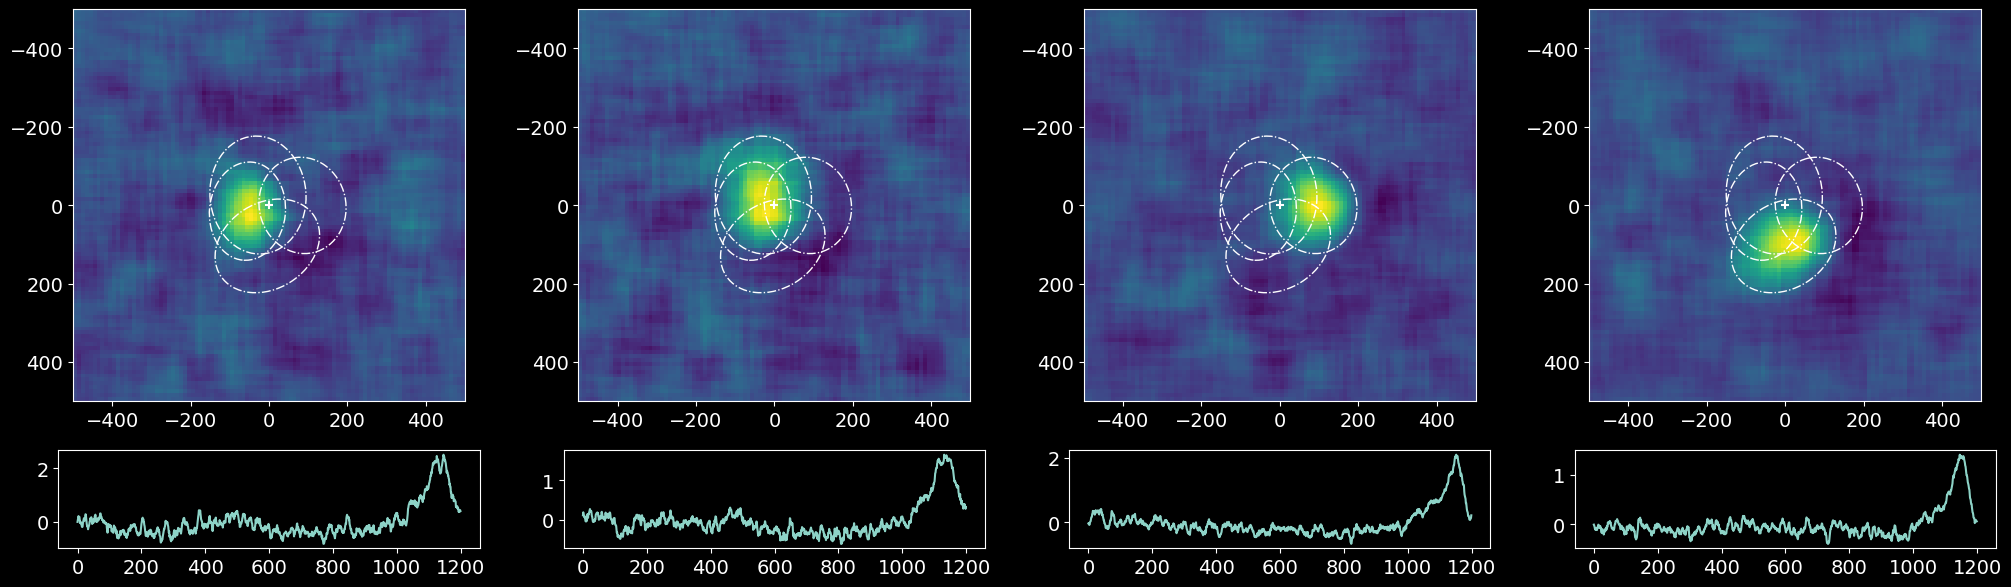

In [91]:
from matplotlib.collections import EllipseCollection
from sklearn.decomposition import PCA
X,Y = np.meshgrid(np.linspace(-sn.epoch_blocks[0]['sizeX']/2, sn.epoch_blocks[0]['sizeX']/2, sta.shape[-2]), np.linspace(-sn.epoch_blocks[0]['sizeY']/2, sn.epoch_blocks[0]['sizeY']/2, sta.shape[-1]))


_,axs = plt.subplots(2,4,figsize=(25,7), gridspec_kw={'height_ratios': [1,.25]})
axs = axs.flatten()

scores = np.empty((nc,sta.shape[0]))
comps = np.empty((nc, *sta.shape[-2:]))
for c in range(nc):
    pca = PCA(1)
    scores[c] = pca.fit_transform(sta[:,c].reshape(sta.shape[0], sta.shape[-2] * sta.shape[-1])).flatten()
    comps[c] = pca.components_.reshape(sta.shape[-2:])
    
    plt.sca(axs[c])
    plt.imshow(comps[c], extent = (-sn.epoch_blocks[0]['sizeX']/2, sn.epoch_blocks[0]['sizeX']/2, sn.epoch_blocks[0]['sizeY']/2, -sn.epoch_blocks[0]['sizeY']/2))
    
    plt.scatter(0,0,c='w',marker='+')

    plt.sca(axs[c+nc])
    plt.plot(scores[c])
    
for c in range(nc):
    f0 = np.median(comps[c])
    amp = comps[c].max() - f0

    popt, _ = curve_fit(gauss2, (X.flatten(), Y.flatten()), comps[c].flatten(), p0=(amp,0,0,50,50,np.pi/4,f0), maxfev=10000)
    amp,cx,cy,sx,sy,th,f0 = popt

    print(cx,cy)
    for ci in range(nc):
        sc = EllipseCollection(offsets = (cx,cy), widths = 4*sx, heights = 4*sy, angles=-th/np.pi*180, units='xy', offset_transform=axs[ci].transData, facecolors='None', edgecolors='w', linestyle='-.')#, facecolors='None', edgecolors=sig)
        axs[ci].add_collection(sc)


In [118]:
np.asarray([[-54.908919993017044, 14.9656050845257],
[-28.043999209523253, -26.072104501863222],
[85.56291711973522, 0.34227627872489214],
[-4.1328035420780775, 103.58213903114608]]).mean(axis=0)

array([-0.38070141, 23.20447897])

In [92]:
# TODO: move to a geometry utils file
# utility functions for working with ellipses
def ellipse_mat_to_params(Q):
    (A,B,D),(_,C,E),(_,_,F) = Q
    B = B*2
    D = D*2
    E = E*2

    l,_ = np.linalg.eig(Q[:-1,:-1])
    if np.abs(l[0]-A) > np.abs(l[0]-C):
        l = [l[1],l[0]]

    M = np.linalg.det(Q[:-1,:-1])
    M0 = np.linalg.det(np.roll(Q,1,(0,1)))

    sx = np.sqrt(-M0/M/l[0])
    sy = np.sqrt(-M0/M/l[1])
    cx = (B*E - 2*C*D)/(4*A*C-B*B)
    cy = (B*D - 2*A*E)/(4*A*C-B*B)
    th = np.arctan2(B, A-C) / 2 - (np.pi/2 * (sx>sy))

    return cx,cy,sx,sy,th

def ellipse_params_to_mat(cx,cy,sx,sy,th):
    Q = np.empty((3,3))
    Q[0,0] = (np.cos(th)/sx)**2 + (np.sin(th)/sy)**2
    Q[1,1] = (np.cos(th)/sy)**2 + (np.sin(th)/sx)**2
    
    Q[0,1] = np.sin(2*th) * (1/sx**2 - 1/sy**2) / 2
    Q[1,0] = Q[0,1]

    Q[0,2] = (cy*np.sin(2*th)*(1/sy**2 - 1/sx**2) - 2*cx*((np.sin(th)/sy)**2 + (np.cos(th)/sx)**2)) / 2
    Q[2,0] = Q[0,2]
    
    Q[1,2] = (cx*np.sin(2*th)*(1/sy**2 - 1/sx**2) - 2*cy*((np.sin(th)/sx)**2 + (np.cos(th)/sy)**2)) / 2
    Q[2,1] = Q[1,2]

    Q[2,2] = ((cx*np.cos(th) + cy*np.sin(th))/sx)**2 + ((cx*np.sin(th) - cy*np.cos(th))/sy)**2 - 1

    return Q

def intersect_conic_line(Q,l):
    # Assumes that Q is not degenerate

    L = np.asarray([
        [0, -l[2], l[1]],
        [l[2], 0, -l[0]],
        [-l[1], l[0], 0],
    ]) # L represents taking a cross-product with l

    D = L.T @ Q @ L # a degenerate conic...
    # this represents the 2 (complex) intersecting points
    # to extract the coordinates, we need to consider the pencil of D and L, P = D + wL
    # if rank(P) == 1, the intersecting points are found by homogenizing a (nonzero) row and column of P
    # For this, det(P[1:,1:]) should be zero (quadratic)
    
    if l[0]!= 0:
        # det(P[1:,1:]) = D[1,1] * D[2,2] - (D[1,2] - w*l[0])(D[2,1] + w*l[0]) = 0
        a = l[0]*l[0]
        b = l[0] * (D[2,1] - D[1,2])
        c = np.linalg.det(D[1:,1:])
    else: # a vertical line; we instead consider a different submatrix
        # P[0,0] * P[2,2] - P[0,2] * P[2,0] = D[0,0] * D[2,0] - (D[0,2] + w*l[1])(D[2,0] - w*l[1]) = 0
        a = l[1]*l[1]
        b = l[1] * (D[0,2]- D[2,0])
        c = D[0,0] * D[2,2] - D[0,2]* D[2,0]

    w = (- b + np.sqrt(b*b - 4*a*c))/(2*a) #quadratic
    P = D + w*L

    # print(P)

    q = np.empty((2,3)) * np.nan # the real intersection points, in homogeneous form
    for j in range(3):
        if ~np.all(np.abs(P[j]) < 1e-14) and ~np.any(np.iscomplex(P[j])):
            q[0] = np.real(P[j] / P[j,-1])
            break
    for j in range(3):
        if ~np.all(np.abs(P[:,j]) < 1e-14) and ~np.any(np.iscomplex(P[:,j])):
            q[1] = np.real(P[:,j] / P[-1,j])
            break

    return q

def intersect_conic_line_2(Q, L):
    #NOTE: seems to only work for some ellipses? gives bad values
    # could have to do with degenerate/noininvertible conics?
    
    qi = np.linalg.inv(Q)

    (a,c,d),(_,b,e),(_,_,f) = qi

    u,v,w = qi @ np.asarray(L)
    K = [
        a*w*w - 2*d*u*w + f*u*u,
        -2*(c*w*w - w*(d*v+e*u) + f*u*v),
        w*w*(b-a) + 2*w*(d*u-e*v) + f*(v*v - u*u),
    ]
    
    asp = np.arcsin(np.clip((2*K[0] + K[2])/np.sqrt(K[1]**2 + K[2]**2),-1,1))

    psi = [
        0.5*(np.arctan(K[1]/K[2]) - asp - np.pi/2),
        0.5*(np.arctan(K[1]/K[2]) + asp + np.pi/2),
            ]
    q = np.asarray([[
        (c*w-d*v)*np.cos(psii) + (d*u-a*w)*np.sin(psii),
        (b*w-e*v)*np.cos(psii) + (e*u-c*w)*np.sin(psii),
        (e*w-f*v)*np.cos(psii) + (f*u-d*w)*np.sin(psii),
            ] for psii in psi])
    q = q / q[:,-1,None]
    return q

def intersect_conic_conic(A,B):
    # will error if A is identically B
    rts,_ = np.linalg.eig(B @ np.linalg.inv(-A))
    # rts defines the 3 degenerate conics through the 4 (complex) intersections of A and B

    q = np.empty((4,3)) * np.nan
    nq = 0
    for i in range(3):
        C = rts[i]*A + B #a degenerate conic of 2 constituent lines

        # p is a row of the adjugate matrix of C
        p = np.asarray([C[1,1]*C[2,2] - C[1,2]*C[2,1], C[1,2]*C[2,0] - C[2,2]*C[1,0], C[1,0]*C[2,1] - C[1,1]*C[2,0]])

        # P represents a cross-product with p
        P = np.asarray([[0, p[2], -p[1]], [-p[2], 0, p[0]], [p[1], -p[0], 0]])

        # C2 is a degenerate conic in the pencil of C and P with rank 1, representing (complex) intersection lines
        # see intersect_conic_line()
        a = np.linalg.det(P[1:,1:])
        b = P[1,1]*C[2,2] + C[1,1,]*P[2,2] - P[2,1]*C[1,2] - P[1,2]*C[2,1]
        c = np.linalg.det(C[1:,1:])
        if a == 0: # complex roots (not intersecting)
            continue
        w = (-b + np.sqrt(b*b - 4*a*c)) / (2*a)
        C2 = C + w*P

        for j in range(3):
            if ~np.all(C2[j] == 0):
                l = C2[j] / C2[j,-1]
                qi = intersect_conic_line(A, l)
                for qii in qi:
                    if np.all(np.isfinite(qii)) and not np.any(np.abs(q-qii).sum(axis=0) < 1e-12):
                        q[nq] = qii
                        nq += 1
                break
        for j in range(3):
            if ~np.all(C2[:,j] == 0):
                l = C2[:,j] / C2[-1,j]
                qi = intersect_conic_line(A, l)
                for qii in qi:
                    if np.all(np.isfinite(qii)) and not np.any(np.abs(q-qii).sum(axis=0) < 1e-12):
                        q[nq] = qii
                        nq += 1                    
                break
    return q

def elliptic_arc(Q, phi):
    cx,cy,sx,sy,th = ellipse_mat_to_params(Q)
    
    x = cx + sx * np.cos(phi) * np.cos(th) - sy * np.sin(phi) * np.sin(th)
    y = cy + sx * np.cos(phi) * np.sin(th) + sy * np.sin(phi) * np.cos(th)
    return x,y

def point_to_ellipse_angle(Q, q):
    # Assumes point q is on ellipse Q

    cx,cy,sx,sy,th = ellipse_mat_to_params(Q)

    # from the above parametric elliptic equations, we have:
    # A*cos(phi) + B*sin(phi) = C
    #   divide both sides by sqrt(A*A + B*B) = D
    #   note that (A/D)**2 + (B/D)**2 == 1 == cos2(x) + sin2(x)
    #   note also that tan(x) = A/B
    #   then:
    # cos(phi)*cos(x) + sin(phi)*sin(x) = C/D
    # cos(phi - x) = C/D
    # phi = 2*pi*n +/- arccos(C/D) + arctan(A/B)

    def intersect_ellipse_axis(A,B,C):
        D = np.sqrt(A*A + B*B)
        at = np.arctan(A/B) 
        ac = np.arccos(C/D)
        p2 = 2*np.pi
        return (at - ac + p2) % p2 , (at + ac + p2) % p2

    phi_x = intersect_ellipse_axis(-sy*np.sin(th), sx*np.cos(th), q[0] - cx)
    
    if np.abs(elliptic_arc(Q, phi_x[0])[1] - q[1]) < np.abs(elliptic_arc(Q, phi_x[1])[1] - q[1]):
        return phi_x[0]
    else:
        return phi_x[1]

def point_in_conic(Q,x,y):
    # The polynomial form of the conic defines an inequality
    # Equality is reached on the boundary of the conic; the interior of the conic is negative 
    # This is clear from (1) the continuous nature of the polynomial wrt x,y, (2) the equation for the circle

    return x*x*Q[0,0] + x*y*Q[0,1]*2 + y*y*Q[1,1] + x*Q[0,2]*2 + y*Q[1,2]*2 + Q[2,2] <= 0



In [93]:
A_q = np.empty((nc, 3, 3))
for c in range(nc):
    f0 = np.median(comps[c])
    amp = comps[c].max() - f0

    popt, _ = curve_fit(gauss2, (X.flatten(), Y.flatten()), comps[c].flatten(), p0=(amp,0,0,50,50,np.pi/4,f0), maxfev=10000)
    amp,cx,cy,sx,sy,th,f0 = popt
    sx,sy = 2*sx,2*sy #the semi-axes for the ellipse, i.e. 4*std width
    th = -th # because why?

    A_q[c] = ellipse_params_to_mat(cx,cy,sx,sy,th)


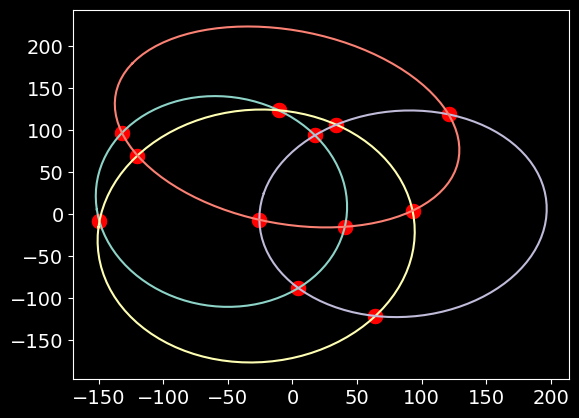

In [94]:
ei = np.empty((nc,nc,4)) * np.nan


for i in range(nc):
    plt.plot(*elliptic_arc(A_q[i], np.linspace(-np.pi,np.pi,100)))

    for j in range(nc):
        if i == j:
            continue
        q = intersect_conic_conic(A_q[i],A_q[j])

        phi = point_to_ellipse_angle(A_q[i], q[0]), point_to_ellipse_angle(A_q[i], q[1])  

        plt.scatter(*elliptic_arc(A_q[i],phi[0]), s=100, marker='o', c='r')
        plt.scatter(*elliptic_arc(A_q[i],phi[1]), s=100, marker='o', c='r')
        
        ei[i,j,:] = sorted([point_to_ellipse_angle(A_q[i], qi) for qi in q]) #do we need to sort here?

    

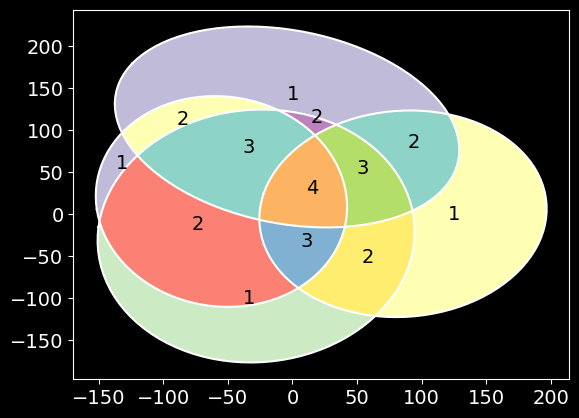

In [95]:

shapes = []
segs = []

for ii in range(nc):
    nzs = np.count_nonzero(~np.isnan(ei[ii]))
    if not nzs:
        shapes.append[[ii, 0, 2*np.pi]]
    for t in range(nzs):
        i = ii
        
        eii = ei[i].flatten() # intersection phis
        p_i = np.argsort(eii) # indices of intersections with increasing phi
        p = eii[p_i[t]] # phi
        k = (t + 1) % np.count_nonzero(~np.isnan(eii)) #index of next intersection
        ccw = True

        shape = []
        tsegs = []
        shape_in = np.empty(nc) * np.nan
        while [i,t,k] not in tsegs: # test to see if shape is closed
            tsegs.append([i, t, k]) # add this segment to the shape

            if ccw and eii[p_i[t]] > eii[p_i[k]]: # wrapped
                shape.append([i,eii[p_i[t]], eii[p_i[k]] + 2*np.pi])
            elif not ccw and eii[p_i[t]] < eii[p_i[k]]: # wrapped
                shape.append([i,eii[p_i[t]] + 2*np.pi, eii[p_i[k]]])
            else:
                shape.append([i,eii[p_i[t]], eii[p_i[k]]])
            shape_in[i] = ccw

            lp = p 

            o = p_i[k]//4 # index of intersecting ellipse
            p = point_to_ellipse_angle(A_q[o], elliptic_arc(A_q[i],eii[p_i[k]])) #phi on intersecting ellipse

            eii = ei[o].flatten()
            p_i = np.argsort(eii) # index 

            j = np.nanargmin(np.abs(eii[p_i] - p)) #phi index on intersecting ellipse
            
            ccw = point_in_conic(A_q[o], *elliptic_arc(A_q[i], lp))
            k =  j + 2 * ccw - 1 # if point in ellipse, move ccw
            if k < 0:
                k = np.count_nonzero(~np.isnan(eii)) - 1 # wrap around cw
            else:
                k = k % np.count_nonzero(~np.isnan(eii)) # wrap around ccw


            i = o #jump to next ellipse
            t = j
        
        if [i,t,k] not in segs: #add this shape
            ni = np.argwhere(np.isnan(shape_in)).flatten() #ellipses we haven't tested this shape against
            for c in ni:
                # we can test any corner for inclusion in the ellipse
                shape_in[c] = point_in_conic(A_q[c], *elliptic_arc(A_q[shape[0][0]], shape[0][1]))

            shapes.append([shape, shape_in])
            segs = [*segs, *tsegs]

for i in range(nc):
    plt.plot(*elliptic_arc(A_q[i], np.linspace(-np.pi,np.pi,100)),'w')
for shape,shape_in in shapes:
    plt_x = np.array([])
    plt_y = np.array([])
    for seg in shape:
        x,y = elliptic_arc(A_q[seg[0]], np.linspace(seg[1], seg[2],100))

        plt_x = np.append(plt_x,x)
        plt_y = np.append(plt_y,y)
    plt.fill(plt_x,plt_y)
    plt.text(plt_x.mean(), plt_y.mean(), str(np.count_nonzero(shape_in)), c='k')


In [14]:
d = 21

# works for shapes with 4 segments
# assumes shapes are in cw or ccw order and that phi is monotonic
pts = np.empty(((d-1)**2,2)) * np.nan
for i in range(1,d):
    #generate edge points
    x0,y0 = elliptic_arc(A_q[shapes[4][0][0][0]], (shapes[4][0][0][1] * i     + shapes[4][0][0][2] * (d-i))/d)
    x2,y2 = elliptic_arc(A_q[shapes[4][0][2][0]], (shapes[4][0][2][1] * (d-i) + shapes[4][0][2][2] * i    )/d)

    for j in range(1,d):
        x1,y1 = elliptic_arc(A_q[shapes[4][0][1][0]], (shapes[4][0][1][1] * j     + shapes[4][0][1][2] * (d-j))/d)
        x3,y3 = elliptic_arc(A_q[shapes[4][0][3][0]], (shapes[4][0][3][1] * (d-j) + shapes[4][0][3][2] * j    )/d)
        
        #interpolate between the opposing lines
        xa = (x0*j + x2*(d-j)) / d
        ya = (y0*j + y2*(d-j)) / d        
        
        xb = (x1*(d-i) + x3*i) / d
        yb = (y1*(d-i) + y3*i) / d

        #interpolate between the overlapping grids
        x = (xa*(i)*(d-i) + xb*(d-j)*j)/(i*(d-i) + j*(d-j))
        y = (ya*(i)*(d-i) + yb*(d-j)*j)/(i*(d-i) + j*(d-j))

        pts[(i-1)*(d-1) + (j-1),:] = (x,y)

(-208.71443244320403,
 352.6502929421083,
 -271.62856863345627,
 289.7361567518561)

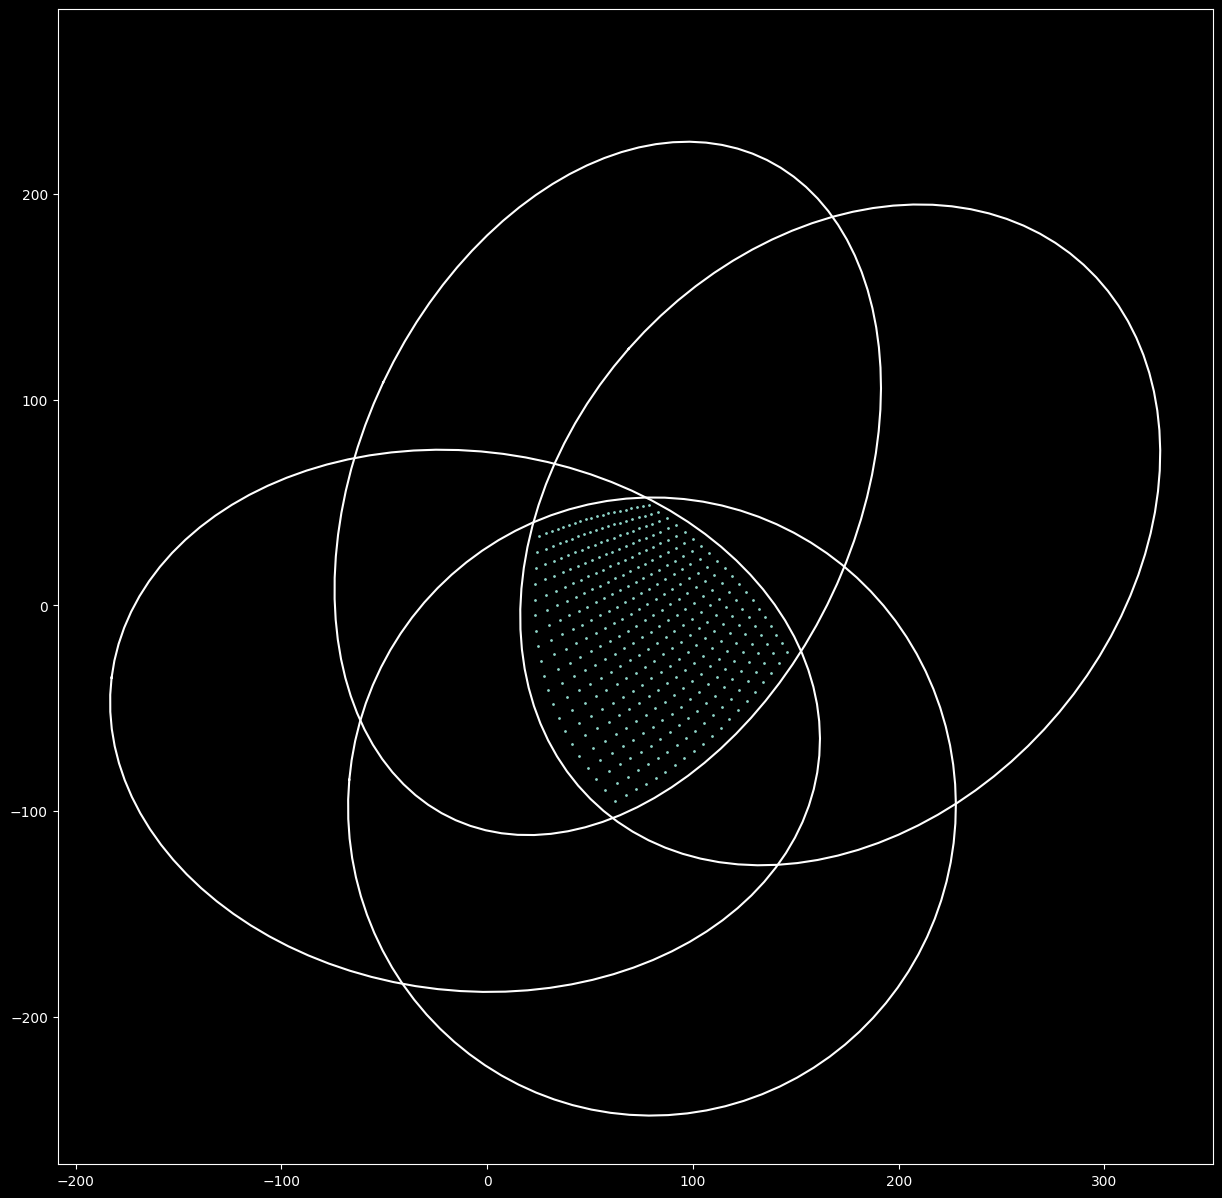

In [15]:
plt.figure(figsize=(15,15))
for i in range(nc):
    plt.plot(*elliptic_arc(A_q[i], np.linspace(-np.pi,np.pi,100)),'w')
plt.scatter(pts[:,0],pts[:,1], s=1)
plt.axis('square')

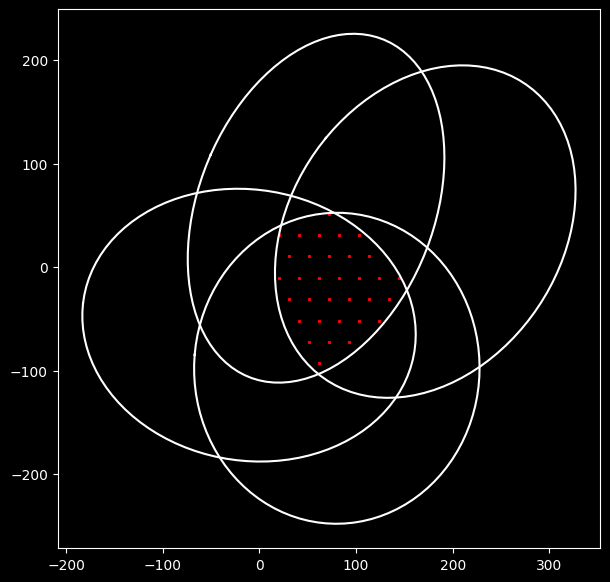

(33,)
(885, 2) (391170,) 20.689655172413723


In [57]:
# X,Y = np.meshgrid(np.arange(-200,350,3), np.arange(-300,300,3))
def gen_hex_grid(nx,ny, phase = 0):
    '''
    Generate a hexagonal grid of cells on [-1,1]
    '''
    x = np.linspace(-1,1,nx)
    y = np.linspace(-1,1,ny)
    dx = 1./(nx-1)

    X,Y = np.meshgrid(x,y)
    for y in range(phase,ny,2):
        X[y] += dx

    # want to drop every 10th spot
    #   i.e., nx*2
    X,Y = X.flatten(), Y.flatten()
    X = np.delete(X, np.arange(nx*(1+phase)-1,nx*ny, nx*2))
    Y = np.delete(Y, np.arange(nx*(1+phase)-1,nx*ny, nx*2))
    

    return X,Y

X,Y = gen_hex_grid(30,30)
X,Y = X*300,Y*300
li = point_in_conic(A_q[0],X,Y) & point_in_conic(A_q[1],X,Y) & point_in_conic(A_q[2],X,Y) & point_in_conic(A_q[3],X,Y) 

plt.figure(figsize=(7,7))
for i in range(nc):
    plt.plot(*elliptic_arc(A_q[i], np.linspace(-np.pi,np.pi,100)),'w')
    plt.scatter(X[li], Y[li],s=1,c='r')

plt.show()
print(X[li].shape)

pts = np.stack((X,Y), axis=-1)

pd = np.linalg.norm(pts[:, None, :] - pts[None, :, :], axis=-1)
di = np.triu_indices(pts.shape[0], 1)
# plt.hist(pd[di],100)

print(pts.shape, di[0].shape, pd[di].min())


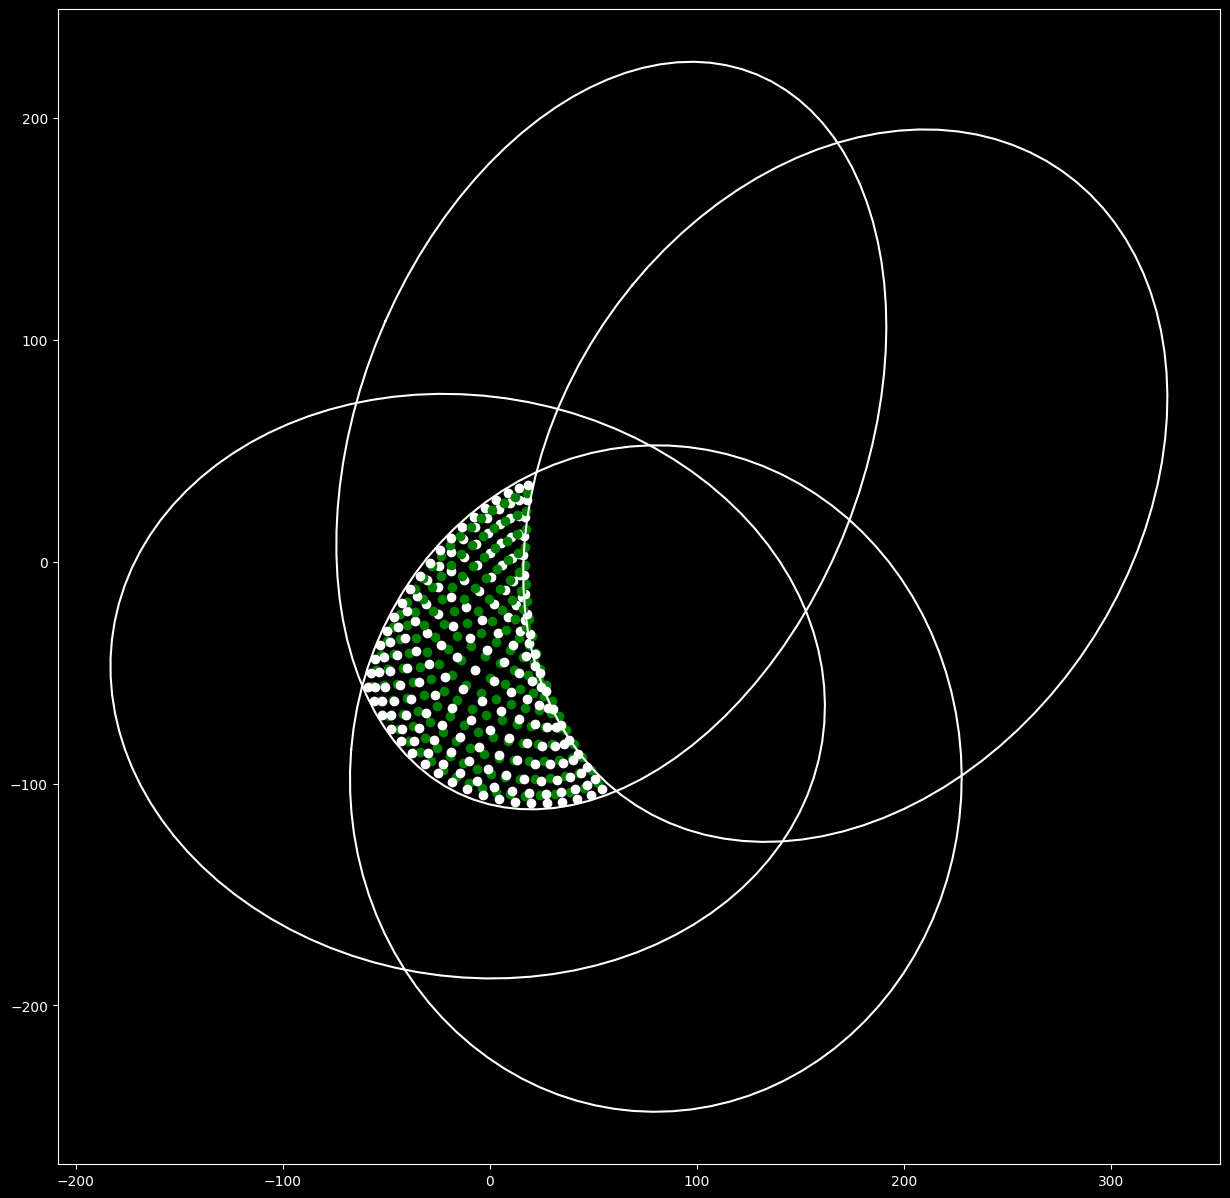

In [17]:
d = 21

# works for shapes with 3 segments

plt.figure(figsize=(15,15))

for i in range(1,d+1):
    for j in range(1,d-i+1):
        k = d-i-j # trilinear coordinates
        if k==0:
            continue
        # we now want to warp i,j,k into our elliptic curves

        x0,y0 = elliptic_arc(A_q[shapes[3][0][0][0]], (shapes[3][0][0][1] * j     + shapes[3][0][0][2] * k)/(j+k))
        x1,y1 = elliptic_arc(A_q[shapes[3][0][1][0]], (shapes[3][0][1][1] * k     + shapes[3][0][1][2] * i)/(k+i))
        x2,y2 = elliptic_arc(A_q[shapes[3][0][2][0]], (shapes[3][0][2][1] * i     + shapes[3][0][2][2] * j)/(i+j))

        x = (x0*j*k + x1*i*k + x2*i*j) / (j*k + i*k + i*j)
        y = (y0*j*k + y1*i*k + y2*i*j) / (j*k + i*k + i*j)
        plt.scatter(x,y,c='g')

        xa = (x0*j*k + x1*i*k) / ( i*k + j*k)
        ya = (y0*j*k + y1*i*k) / ( i*k + j*k)

        # plt.scatter(xa,ya,c='c')
        # plt.text(x,y,f"{i},{j},{k}")
        # print(i,j,k, ",", j*k, i*k, i*j)

        
        xb = (x0*j*k + x2*i*j) / (i*j + j*k)
        yb = (y0*j*k + y2*i*j) / (i*j + j*k)        
        # plt.scatter(xb,yb,c='y')

        xc = (x1*i*k + x2*i*j) / (i*j + i*k)
        yc = (y1*i*k + y2*i*j) / (i*j + i*k)        
        # plt.scatter(xc,yc,c='m')

        plt.scatter((xa*k*k+xb*j*j+xc*i*i)/(i*i + j*j + k*k),(ya*k*k+yb*j*j+yc*i*i)/(i*i + j*j + k*k), c='w')


for i in range(nc):
    plt.plot(*elliptic_arc(A_q[i], np.linspace(-np.pi,np.pi,100)),'w')
# # plt.scatter(pts[:,0],pts[:,1], s=1)
# plt.axis('square')

((400, 2), (79800,), 2.8290484044964606)

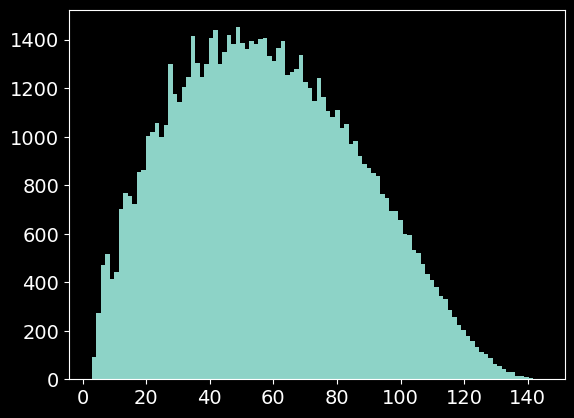

In [2067]:
pd = np.linalg.norm(pts[:, None, :] - pts[None, :, :], axis=-1)
di = np.triu_indices(pts.shape[0], 1)
plt.hist(pd[di],100)
pts.shape, di[0].shape, pd[di].min()

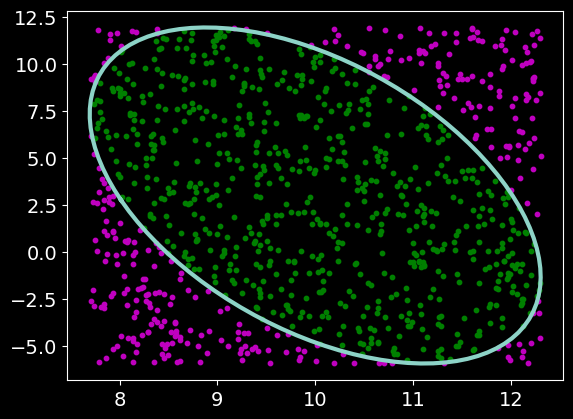

In [1727]:
# let A,B,C be 3 ellipses

# 1) get all intersection points
# 2) if A,B do not intersect, check if A(cx,cy) in B, s.t. A < B, etc.
# 3) A & B & C is not empty iff 1+ intersection of A,B is in C, etc.
# 4) 


a = ellipse_params_to_mat(10, 3, 9, 2, np.pi/2+np.pi/6-np.pi/8)

xc, yc = elliptic_arc(a, np.linspace(-np.pi,np.pi,100))

plt.plot(xc,yc,linewidth=3)
x,y = np.random.rand(1000) * (xc.max()-xc.min()) + xc.min(), np.random.rand(1000) * (yc.max()-yc.min()) + yc.min()

inellipse = x*x*a[0,0] + x*y*a[0,1]*2 + y*y*a[1,1] + x*a[0,2]*2 + y*a[1,2]*2 + a[2,2] <= 0


plt.scatter(x[inellipse],y[inellipse],10,'g')
plt.scatter(x[~inellipse],y[~inellipse],10,'m')

In [106]:
# for k,v in sml.epoch_blocks[2].items():
#     print(k, ":", v)
    #stage coordinates:
    # 493.0, 733.0 -> 553,623 => 60, -110
    # no offset shift
    # but we should have moved (75,-15) ?

for eb in sml.epoch_blocks:
    print(eb['seed'], len(eb['epochs']['start_time']),eb['offsetX'], eb['offsetY'], eb['stageX'], eb['stageY'])

0 10 0.0 0.0 918.0 281.0
0 4 0.0 0.0 935.0 267.0
0 12 0.0 0.0 950.0 306.0
0 13 0.0 0.0 950.0 306.0
0 13 0.0 0.0 952.0 -317.0


In [98]:
print(len(sml.epoch_blocks))
ticks = sml.epoch_blocks[0]['epochs']['start_time']
for tick in ticks:
    d = datetime.datetime(1, 1, 1) + datetime.timedelta(microseconds = tick//10)
    print(d)


5
2023-08-17 19:37:08.084880
2023-08-17 19:41:30.826904
2023-08-17 19:45:00.702912
2023-08-17 19:43:15.238872
2023-08-17 19:38:53.531904
2023-08-17 19:40:38.462912
2023-08-17 19:39:44.963856
2023-08-17 19:38:01.016912
2023-08-17 19:42:22.541864
2023-08-17 19:44:07.937896


In [122]:
# plt.figure(figsize=(30,5))
# plt.plot(p.epoch_blocks[0]['epochs']['response'][-1,0,:].reshape((-1,28)))
# p.epoch_blocks[0]['epochs']['response'][-1,0,:].shape
# 350000/28
# ebs = [0,1,2]
# ebs = [0]
ebs = [2,3]
# prominence = 5
prominence = 5
sc = []
st = []
cx = []
cy = []
r = [] #neb -by- ne -by- (nc -by- nt)
s = [] #neb -by- ne -by-  nc -by- (ns)

offset = 0
for eb in ebs:
    cx_, cy_ = sml.epoch_blocks[eb]['epochs']['cx'].flatten(), sml.epoch_blocks[eb]['epochs']['cy'].flatten()
    ne, nc, nt = sml.epoch_blocks[eb]['epochs']['response'].shape

    r_ = []
    sc_ = np.empty((nc, ne, 28))
    st_ = np.zeros((nc, ne, 28 * 12500))
    s_ = []
    for j,t in enumerate(sml.epoch_blocks[eb]['epochs']['response']): #nc-by-350k
        t = (t - t.mean(axis=-1, keepdims=True)) / t.std(axis=-1, keepdims=True)
        r_.append(t)

        si = []
        for c in range(nc):
            si_,*_ = find_peaks(-t[c], prominence=prominence, distance=10)
            sc_[c,j,:] = np.bincount(si_//12500, minlength=28)
            st_[c,j,si_] = 1
            si.append(si_ + offset)
        s_.append(si)
        offset += t.shape[1]


    st_ = st_.reshape((nc, ne*28, 12500))
    sc_ = sc_.reshape((nc, ne*28))
    r.append(r_)
    s.append(s_)


    cx.append(cx_)
    cy.append(cy_)
    st.append(st_)
    sc.append(sc_)
    # plt.vlines(i, -10,10, color='w')
    # plt.plot(-t,'r')
cx = np.concatenate(cx)
cy = np.concatenate(cy)
st = np.concatenate(st, axis=1)
sc = np.concatenate(sc, axis=1)


In [123]:
u,ui = np.unique(np.stack((cx,cy)), axis=1, return_inverse=True)
print(ui.shape)

t_tot = np.array([st[:, ui == i].mean(axis=1) for i in range(u.shape[1])]) #shape ns-by-nc-by-12500

bl = t_tot[:,:,:2500].sum(axis=-1)


ti = np.linspace(-.25,1, 12500)
psth = np.empty((u.shape[1], nc, 11501))
for i in range(u.shape[1]):
    for c in range(nc):
        psth[i,c,:] = np.convolve(t_tot[i,c], 10*np.ones(1000), 'valid')


(700,)


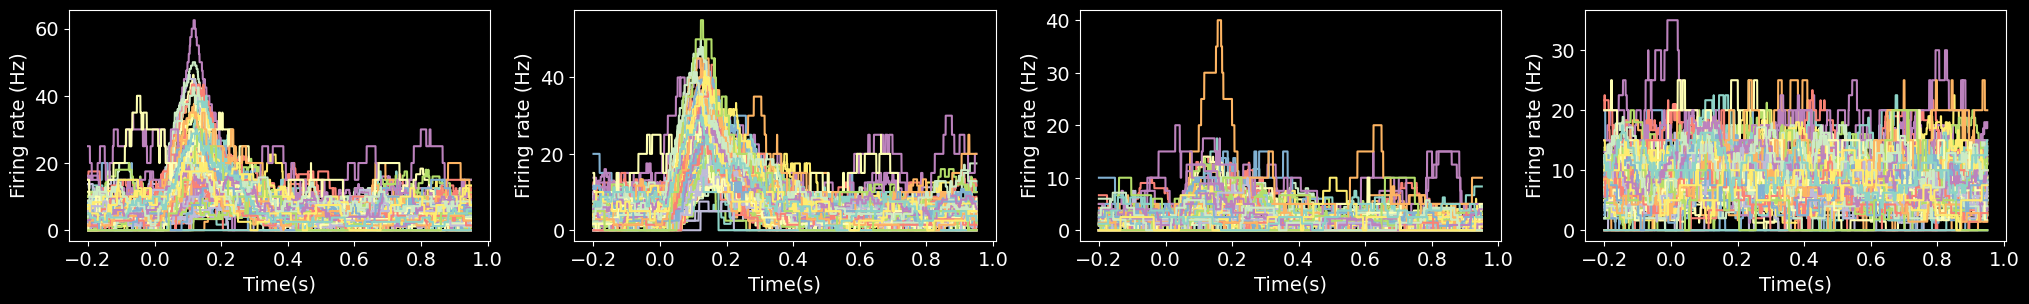

In [124]:
mpl.rcParams.update({'font.size': 14})

_,axs = plt.subplots(1,nc,figsize=(25,3))
for c in range(nc):
    axs[c].set_ylabel('Firing rate (Hz)')
    axs[c].set_xlabel('Time(s)')
    for i in range(u.shape[1]):
        # axs[c].plot(ti[500:-499], psth[i,c,:] - psth[i,c,ti[500:-499]<0].mean())
        
        axs[c].plot(ti[500:-499], psth[i,c,:])
    
    

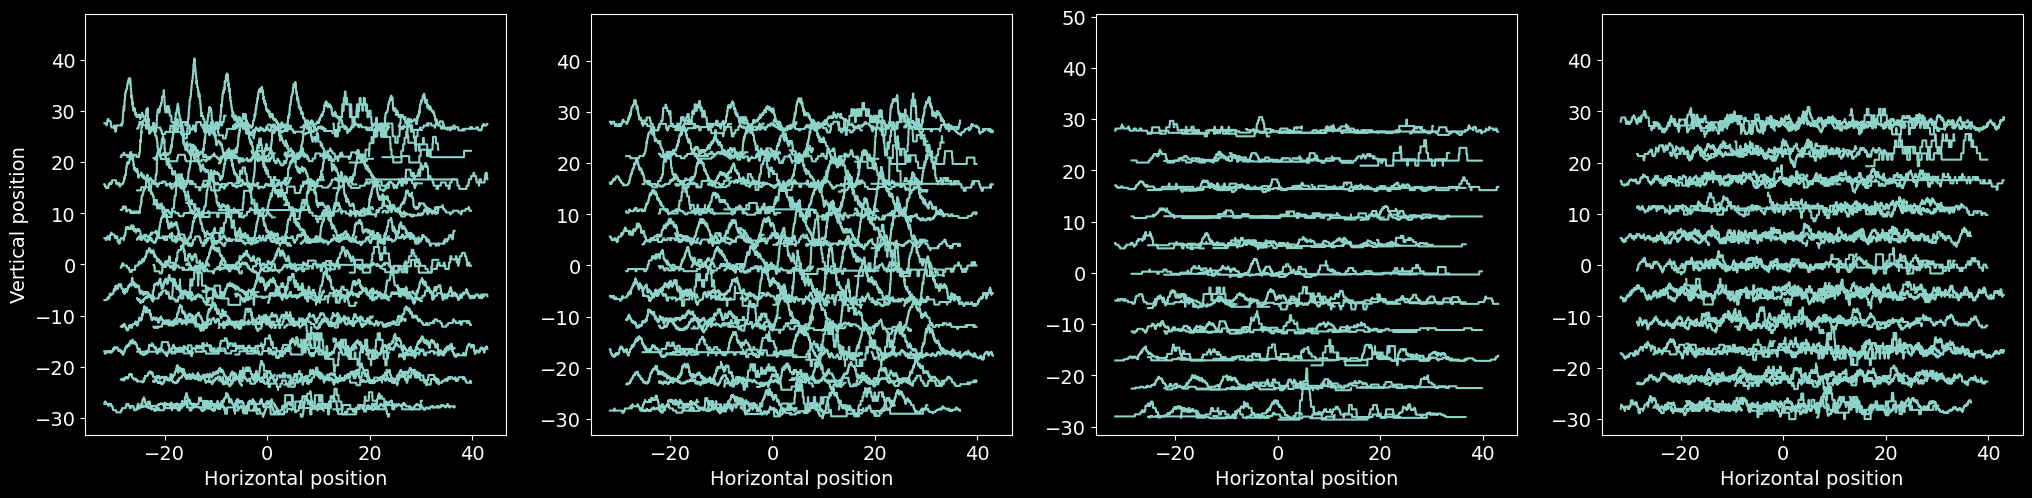

In [125]:
# np.argmax(r_mu)
# u[:,28]
_,axs = plt.subplots(1,nc,figsize=(25,25))

ti = np.linspace(-.25,1, 12500)
cl = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]

# plt.plot(t_tot[28])
for c in range(nc):
    plt.sca(axs[c])
    for i in range(u.shape[1]):
        plt.plot(15*ti[500:-499] + u[0,i], .25*(psth[i,c,:] - psth[i,c,:].mean()) + u[1,i], c=cl)

    plt.gca().invert_yaxis
    plt.xlim(-125,125)
    plt.ylim(-125,125)
    plt.axis('square')
    if c==0:
        plt.ylabel('Vertical position')
    plt.xlabel('Horizontal position')

# plt.axis('square')

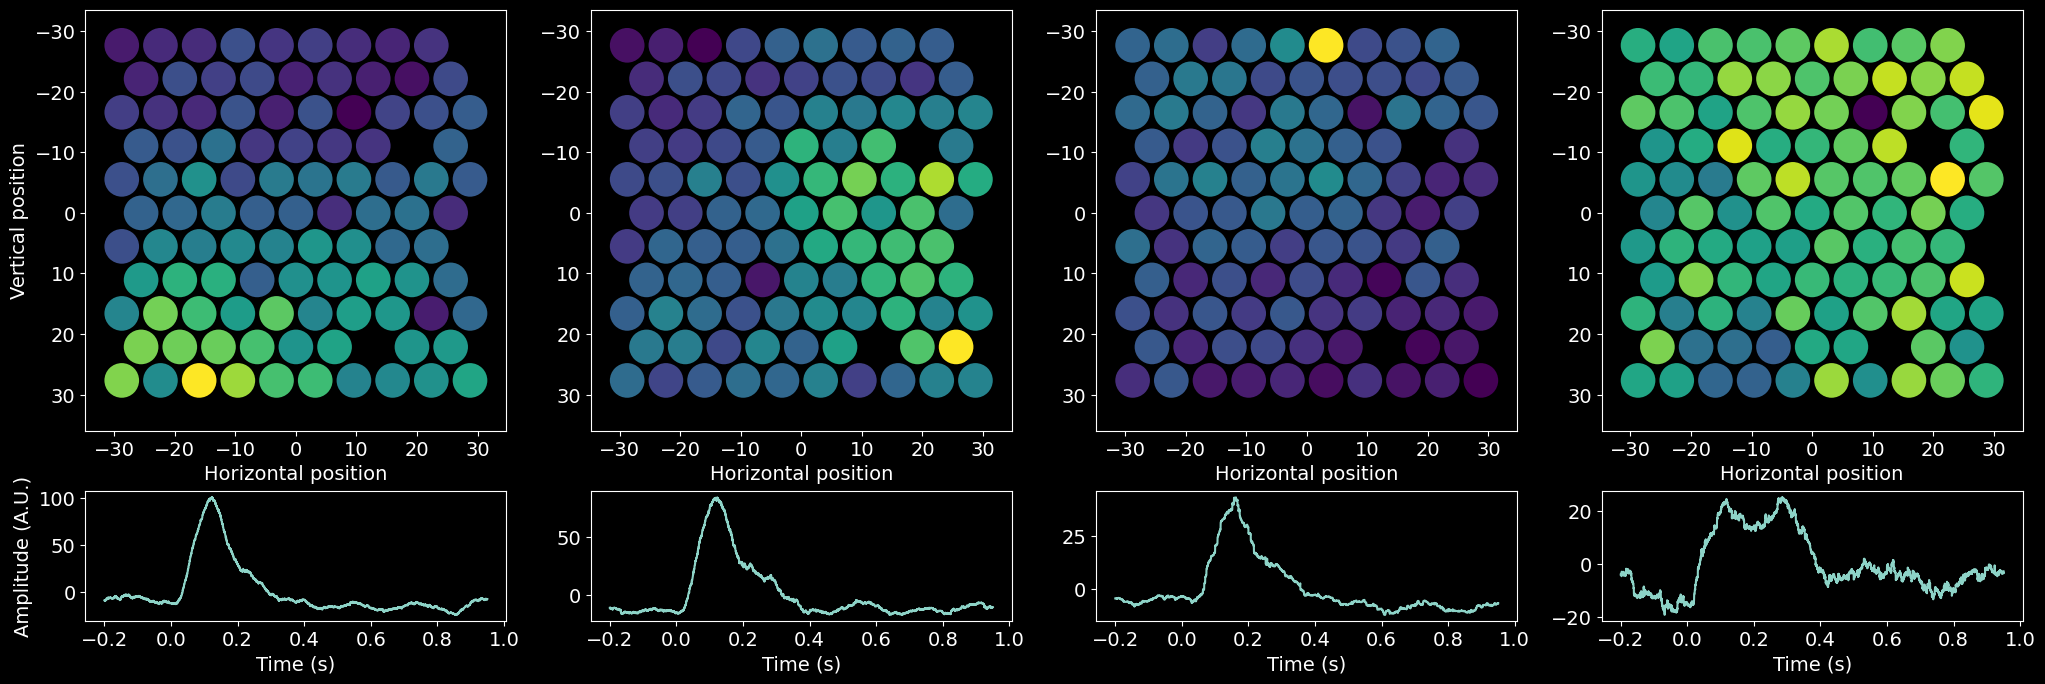

In [129]:
_,axs = plt.subplots(2,nc,figsize=(25,8), gridspec_kw={'height_ratios':[1,.3]})


for c in range(nc):
    ri = psth[:,c,:] - psth[:,c,:].mean(axis=0)

    pca = PCA(1)
    scores = pca.fit_transform(ri.T)
    # l,v = np.linalg.eig(np.cov(ri))
    
    # if the max abs loading is negative, flip it
    # if v[np.abs(v[:,0]).argmax(),0] < 0:
    #     v[:,0] = -v[:,0]
    # v[:,0] /= v[np.abs(v[:,0]).argmax(),0] 

    #can't reuse artists...
    patches = [plt.Circle(cxy,(u.max()-u.min())/np.sqrt(u.shape[1])/2) for cxy in u.T]
    coll = matplotlib.collections.PatchCollection(patches)


    # coll.set_array(np.abs(v[:,0]))
    coll.set_array(pca.components_.squeeze())
    axs[0,c].add_collection(coll)

    axs[0,c].axis('square')

    if c==0:
        axs[0,c].set_ylabel('Vertical position')
    axs[0,c].set_xlabel('Horizontal position')
    axs[0,c].invert_yaxis()

    
    # comp = v[:,0] @ ri
    # comp /= comp[np.abs(comp).argmax()]
    # axs[1,c].plot(ti[500:-499], comp)
    axs[1,c].plot(ti[500:-499], scores)
    
    if c==0:
        axs[1,c].set_ylabel('Amplitude (A.U.)')
    axs[1,c].set_xlabel('Time (s)')

C:\Users\zfj\AppData\Local\Temp\ipykernel_28436\352974471.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  si = np.asarray([e for eb in s for e in eb]).T


(0.27545839036718395, 26.671778434878874)

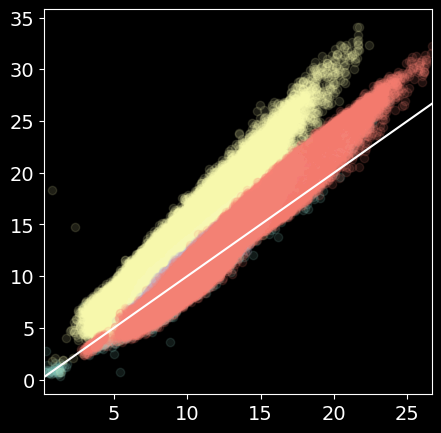

In [10]:

# r = [] #neb -by- ne -by- (nc -by- nt)
# s = [] #neb -by- ne -by-  nc -by- (ns)

b,a = butter(1, 1200, 'highpass', fs=10000)

y = np.asarray([[filtfilt(b, a, c).reshape((28, 12500)) for c in e] for eb in r for e in eb])
y = np.moveaxis(y, 1, 0).reshape((nc,-1))

x = np.asarray([e for eb in r for e in eb])
x = np.moveaxis(x, 1, 0).reshape((nc,-1))

si = np.asarray([e for eb in s for e in eb]).T
si = [np.asarray([p for e in c for p in e]) for c in si]

# # y = t

y = (y - y.mean(axis=1, keepdims=True)) / y.std(axis=1, keepdims=True)
x = (x - x.mean(axis=1, keepdims=True)) / x.std(axis=1, keepdims=True)

plt.figure(figsize=(5,5))

xl = -max([x[c,si[c]].max() for c in range(nc)]), -min([x[c,si[c]].min() for c in range(nc)])

plt.plot(xl,xl,'w')
for c in range(nc):
    plt.scatter(-x[c,si[c]],-y[c,si[c]], alpha=.125)
plt.xlim(xl)


array([   87,   841,  2870,  3361,  3388,  3433,  3460,  3547,  3735,
        3772,  4041,  4153,  4565,  4594,  4725,  5274,  5302,  5366,
        5678,  5766,  6285,  9523,  9811, 11455, 11549, 12510, 13222,
       14738, 16028, 16162, 16465, 16846, 17584, 18080, 18112, 18859,
       20896, 20936, 21603, 21672, 22726, 23373, 24536, 24581],
      dtype=int64)

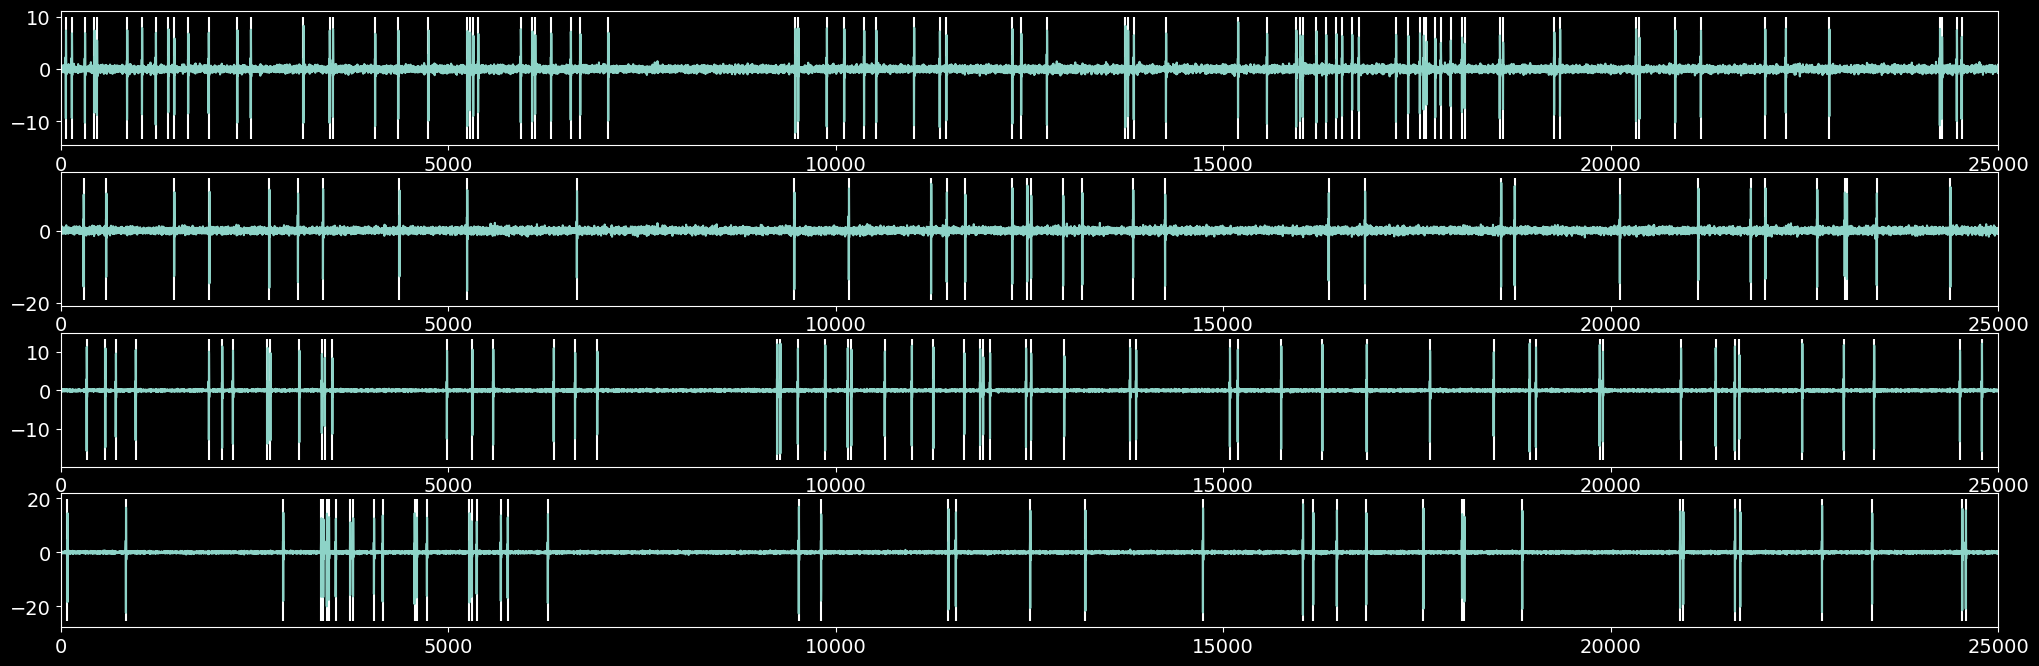

In [11]:

_,axs = plt.subplots(nc,1,figsize=(25,2*nc))
for c in range(nc):
    plt.sca(axs[c])
    yl = y[c,-25000:].min() * 1.1, y[c,-25000:].max() * 1.1

    plt.vlines(si[c][si[c]>y.shape[1]-25000] - y.shape[1] + 25000,*yl)
 
    plt.plot(y[c,-25000:])
    plt.xlim(0, 25000)

# c = 0
si[c][si[c]>y.shape[1] - 25000] - y.shape[1] + 25000
# c = 0
# # plt.plot(y[c,-25000:])
# # yl = y[c,-25000:].min() * 1.1, y[c,-25000:].max() * 1.1
# # print(yl)
# si[c][si[c]>y.shape[1]-25000]

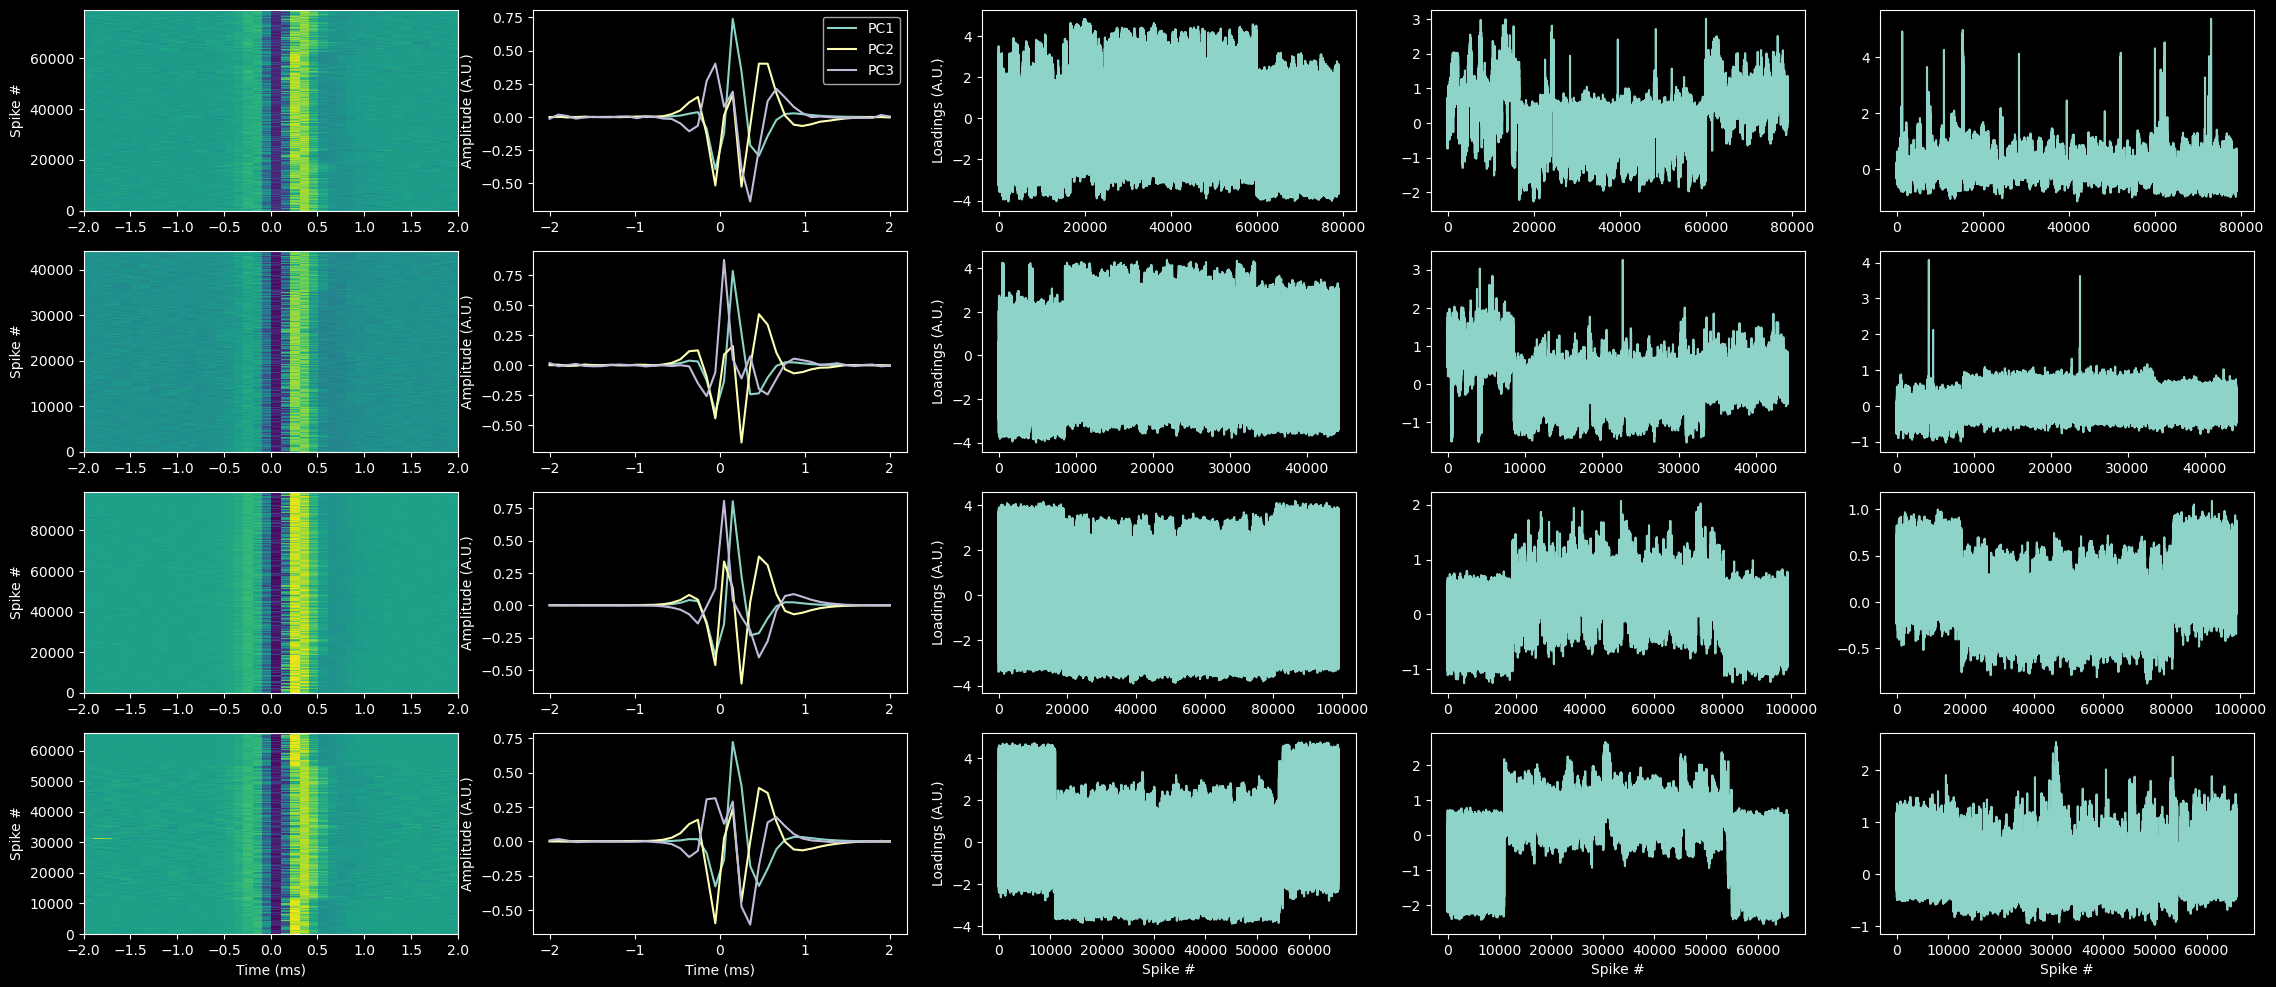

In [259]:
from sklearn.decomposition import PCA
mpl.rcParams.update({'font.size': 10})



_,axs = plt.subplots(nc,5,figsize=(28,3*nc))

for c in range(nc):
    ii = (si[c][:,None] + np.arange(-20,20)[None,:])
    # best_s = np.argmax(np.corrcoef(y[c,ii].T).sum(axis=0))
    # # plt.plot(np.correlate(y[ii[0]], y[ii[1]],'full'))
    # #TODO: subsample offsets

    # offsets = np.asarray([np.correlate(y[c,s], y[c,ii[best_s]],'full').argmax() - 39 for s in ii])
    # offsets.shape, ii.shape
    # ymat = y[c,ii + offsets[:,None]]
    ymat = y[c,ii]
    ymat -= ymat.mean(axis = 1, keepdims = True)
    ymat /= ymat.std(axis = 1, keepdims = True)
    

    #pca
    pca = PCA(3)
    d = pca.fit_transform(ymat)

    axs[c,0].imshow(ymat, interpolation='none', extent = [-2,2,0,ymat.shape[0]])
    axs[c,0].axis('tight')        
    axs[c,0].set_ylabel('Spike #')
    if c == (nc-1):
        axs[c,0].set_xlabel('Time (ms)')
        axs[c,1].set_xlabel('Time (ms)')
    
    axs[c,1].set_ylabel('Amplitude (A.U.)') 
    axs[c,2].set_ylabel('Loadings (A.U.)')
    

    for i in range(3):    
        # v[:,i] /= v[np.abs(v[:,i]).argmax(),i] 


        axs[c,1].plot(np.linspace(-2,2,40), pca.components_[i])

        axs[c,i+2].plot(d[:,i])
        axs[c,i+2].axis('tight')

        if c == (nc-1):
            axs[c,i+2].set_xlabel('Spike #')
 
    if c == 0:
        axs[c,1].legend(['PC1','PC2','PC3'])




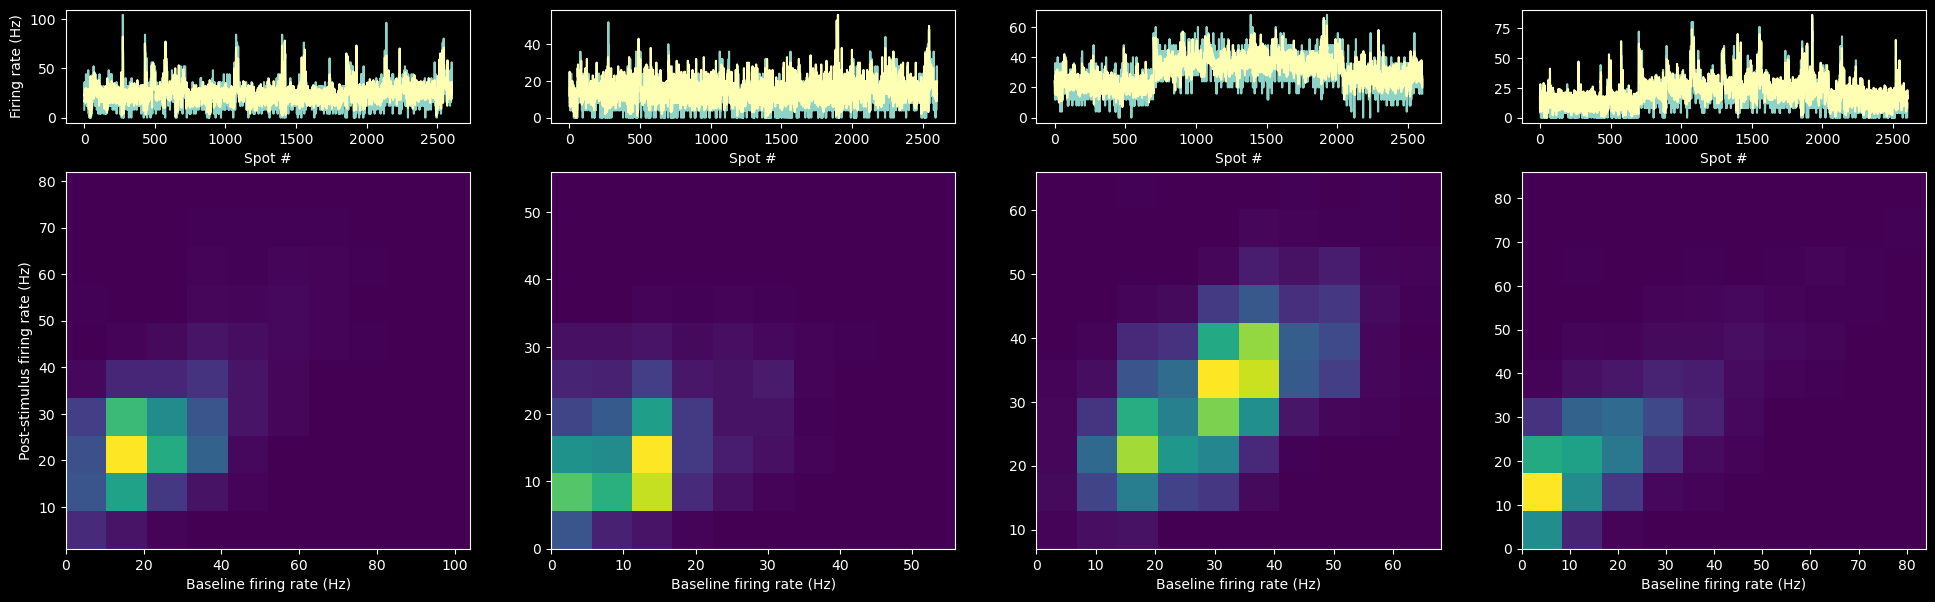

In [260]:
# plt.figure(figsize=(10,10))
# plt.imshow(st, aspect=20, interpolation='none')
# plt.plot(st.sum(axis=1))

_,axs = plt.subplots(2,nc,figsize=(6*nc, 7),  gridspec_kw={'height_ratios':[.3,1]})
for c in range(nc):    
    axs[0,c].plot(st[c,:,:2500].sum(axis=1)*4)
    axs[0,c].plot(st[c,:,2500:].sum(axis=1))

    # plt.scatter(st[:,:2500].sum(axis=1)*4, st[:,2500:].sum(axis=1))
    axs[1,c].hist2d(st[c,:,:2500].sum(axis=1)*4, st[c,:,2500:].sum(axis=1))
    # axs[1,c].axis('square')

    axs[0,c].set_xlabel('Spot #')
    if c==0:
        axs[0,c].set_ylabel('Firing rate (Hz)')
        axs[1,c].set_ylabel('Post-stimulus firing rate (Hz)')
    axs[1,c].set_xlabel('Baseline firing rate (Hz)')
    

In [12]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import StratifiedKFold as KFold
from keras.utils import to_categorical 

cv = KFold(10, shuffle=True, random_state=0)
# dat = sc2.T
dat = np.concatenate((st[:,:,2500:6000].sum(axis=-1),  st[:,:,:2500].sum(axis=-1)), axis=0).T


train, test = list(cv.split(dat, ui))[0]

xtrain, xtest = dat[train], dat[test]
ytrain, ytest = u.T[ui[train],:], u.T[ui[test],:]
ltrain, ltest = ui[train], ui[test]

ncells = 4

In [13]:
width = 64
depth = 12

tmi = layers.Input(ncells * 2)
ffn = layers.Dense(width, activation='sigmoid')(tmi)
tmii = layers.LayerNormalization()(ffn)
ffn = tmii

for i in range(depth):
    ffn = layers.Dense(width, activation='sigmoid')(ffn)
    ffn = layers.Add()([tmii, ffn])
    ffn = layers.LayerNormalization()(ffn)

ffn = layers.Dense(2)(ffn)
mod = keras.Model(inputs=tmi, outputs = ffn)
mod.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 64)           576         ['input_1[0][0]']                
                                                                                                  
 layer_normalization (LayerNorm  (None, 64)          128         ['dense[0][0]']                  
 alization)                                                                                       
                                                                                                  
 dense_1 (Dense)                (None, 64)           4160        ['layer_normalization[0][0]']

In [14]:
mod.compile(
    # loss = 'categorical_crossentropy',
    loss = 'mse',
    # loss = 'absolute_error',
    
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=tf.keras.metrics.RootMeanSquaredError()
)
history = mod.fit(xtrain, ytrain, validation_data=(xtest,ytest), epochs=200, callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',restore_best_weights=True, patience=10, verbose=1))
# history = mod.fit(xtrain, ltrain, validation_data=(xtest,ltest), epochs=200, callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',restore_best_weights=True, patience=20, verbose=1))


Epoch 1/200
74/74 [==============================] - 2s 7ms/step - loss: 4036.6482 - root_mean_squared_error: 63.5346 - val_loss: 3757.9250 - val_root_mean_squared_error: 61.3019
Epoch 2/200
74/74 [==============================] - 0s 3ms/step - loss: 3505.8262 - root_mean_squared_error: 59.2100 - val_loss: 3280.8208 - val_root_mean_squared_error: 57.2785
Epoch 3/200
74/74 [==============================] - 0s 3ms/step - loss: 3046.1873 - root_mean_squared_error: 55.1923 - val_loss: 2846.6448 - val_root_mean_squared_error: 53.3540
Epoch 4/200
74/74 [==============================] - 0s 3ms/step - loss: 2621.2280 - root_mean_squared_error: 51.1979 - val_loss: 2465.0383 - val_root_mean_squared_error: 49.6492
Epoch 5/200
74/74 [==============================] - 0s 3ms/step - loss: 2262.4993 - root_mean_squared_error: 47.5657 - val_loss: 2142.8318 - val_root_mean_squared_error: 46.2907
Epoch 6/200
74/74 [==============================] - 0s 3ms/step - loss: 1966.4174 - root_mean_squared_er

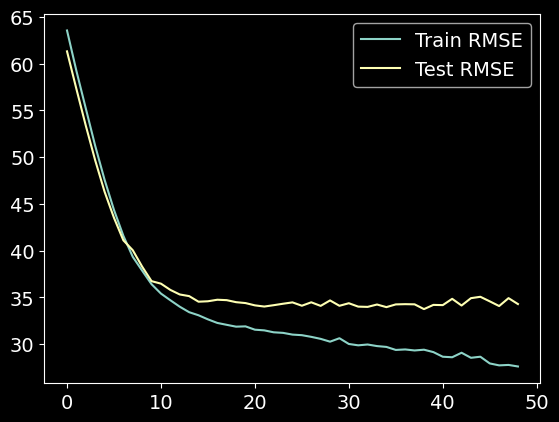

In [16]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.legend(['Train RMSE', 'Test RMSE'])


In [17]:
ptest = mod.predict(xtest)

9/9 [==============================] - 0s 2ms/step


In [18]:
def rand_cmap(nlabels, type='bright', first_color_black=True, last_color_black=False, verbose=True):
    """
    Creates a random colormap to be used together with matplotlib. Useful for segmentation tasks
    :param nlabels: Number of labels (size of colormap)
    :param type: 'bright' for strong colors, 'soft' for pastel colors
    :param first_color_black: Option to use first color as black, True or False
    :param last_color_black: Option to use last color as black, True or False
    :param verbose: Prints the number of labels and shows the colormap. True or False
    :return: colormap for matplotlib
    """
    from matplotlib.colors import LinearSegmentedColormap
    import colorsys
    import numpy as np


    if type not in ('bright', 'soft'):
        print ('Please choose "bright" or "soft" for type')
        return

    if verbose:
        print('Number of labels: ' + str(nlabels))

    # Generate color map for bright colors, based on hsv
    if type == 'bright':
        randHSVcolors = [(np.random.uniform(low=0.0, high=1),
                          np.random.uniform(low=0.2, high=1),
                          np.random.uniform(low=0.9, high=1)) for i in range(nlabels)]

        # Convert HSV list to RGB
        randRGBcolors = []
        for HSVcolor in randHSVcolors:
            randRGBcolors.append(colorsys.hsv_to_rgb(HSVcolor[0], HSVcolor[1], HSVcolor[2]))

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]

        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Generate soft pastel colors, by limiting the RGB spectrum
    if type == 'soft':
        low = 0.6
        high = 0.95
        randRGBcolors = [(np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high)) for i in range(nlabels)]

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]
        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Display colorbar
    if verbose:
        from matplotlib import colors, colorbar
        from matplotlib import pyplot as plt
        fig, ax = plt.subplots(1, 1, figsize=(15, 0.5))

        bounds = np.linspace(0, nlabels, nlabels + 1)
        norm = colors.BoundaryNorm(bounds, nlabels)

        cb = colorbar.ColorbarBase(ax, cmap=random_colormap, norm=norm, spacing='proportional', ticks=None,
                                   boundaries=bounds, format='%1i', orientation=u'horizontal')

    return random_colormap

(-117.64324973602355,
 115.60204023286171,
 -114.33793404164722,
 114.78994957722502)

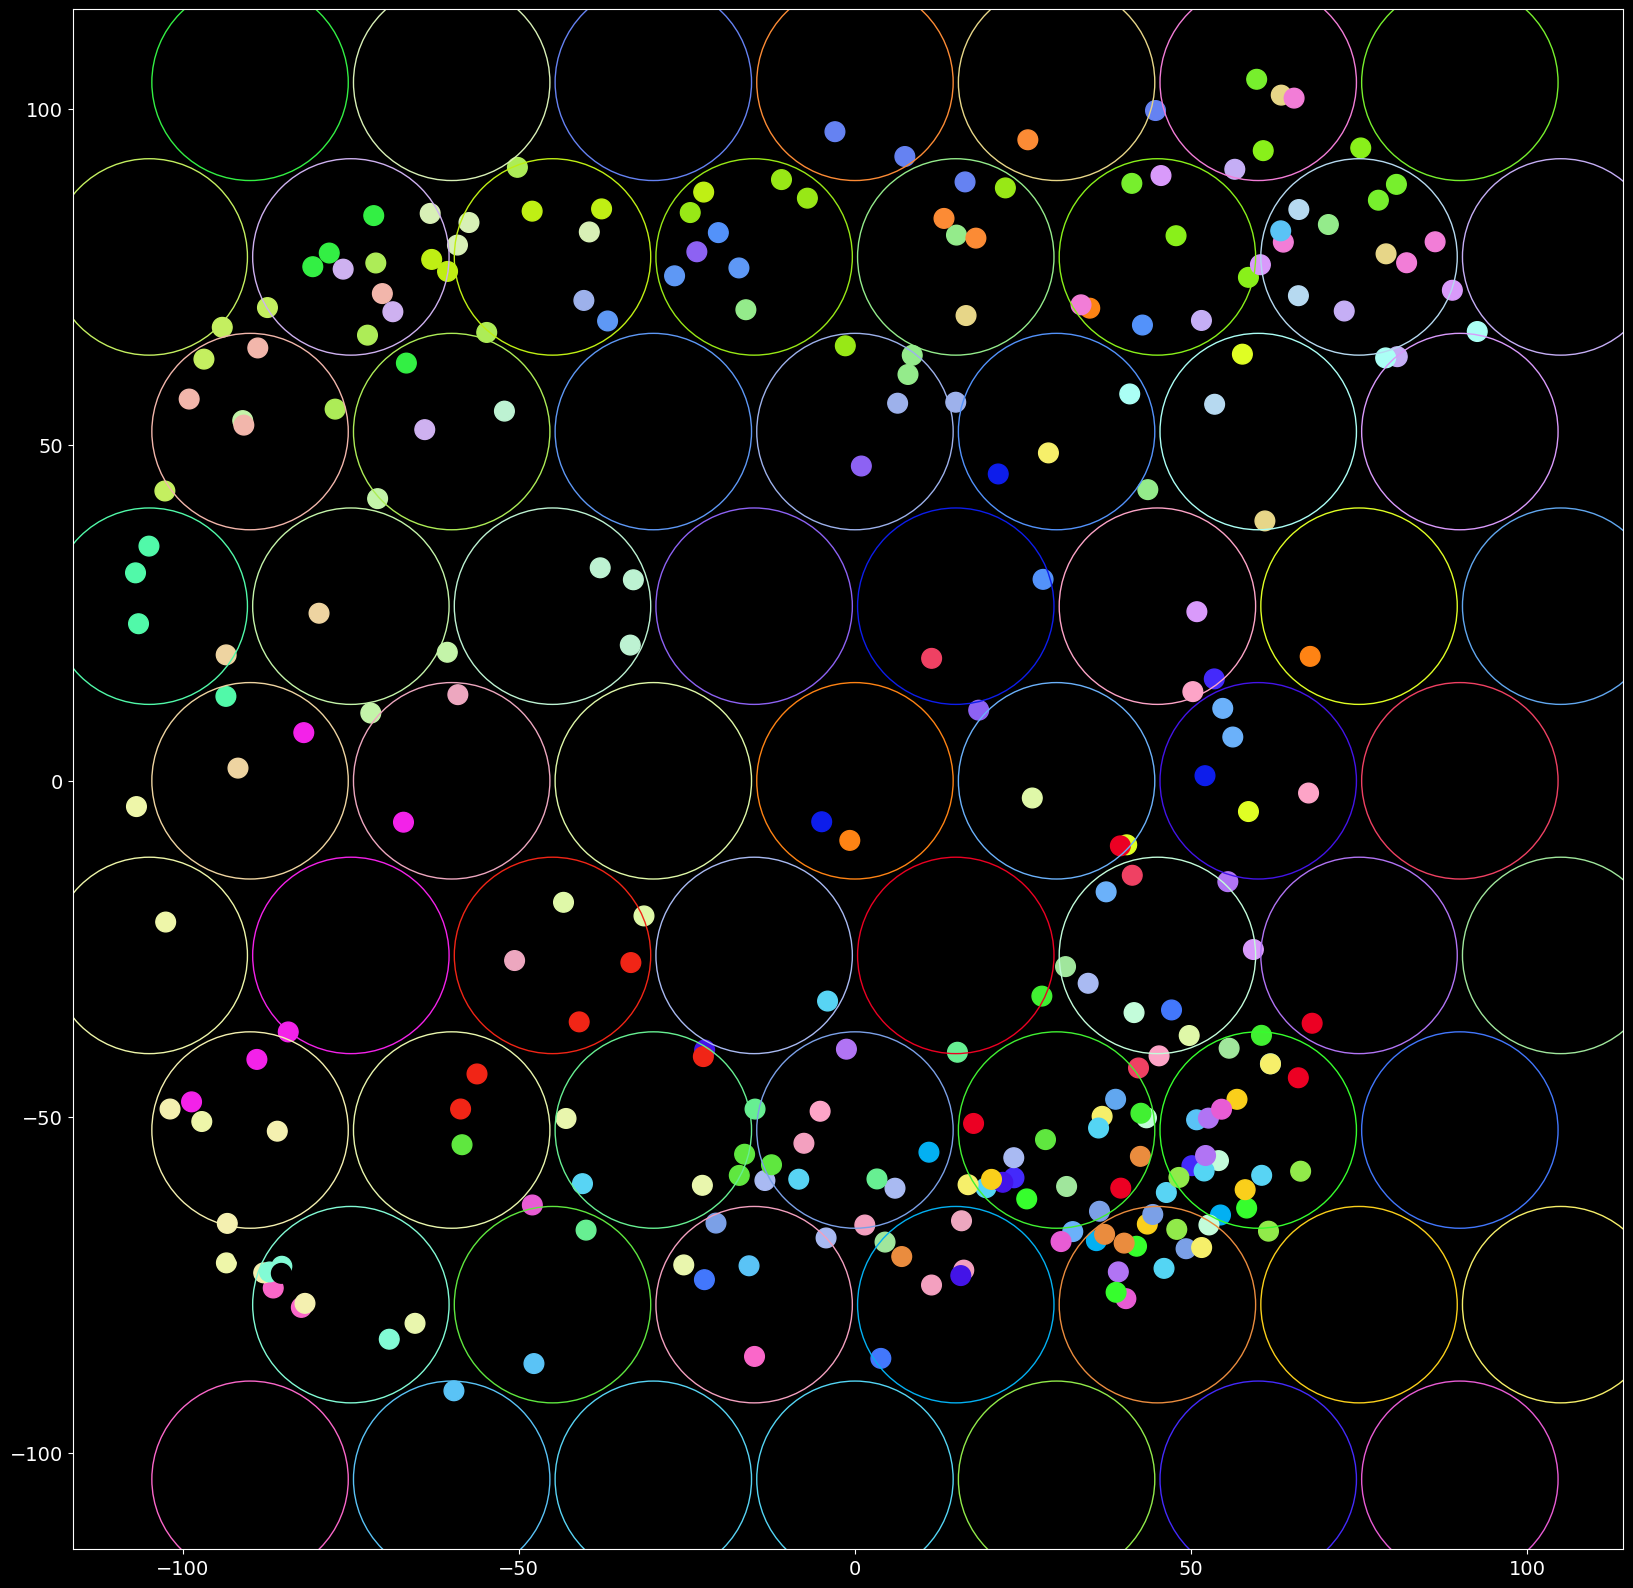

In [19]:
# cmap = 'gist_ncar'
cmap = rand_cmap(u.shape[1], type='bright', first_color_black=True, last_color_black=False, verbose=False)

plt.figure(figsize=(20,20))
plt.scatter(*ptest.T, 200, c=ltest, cmap=cmap)
plt.scatter(*u, 20000, facecolors='none', edgecolors = [cmap(i) for i in range(u.shape[1])])#, edgecolors = np.arange(u.shape[1]), cmap=cmap)
plt.axis('equal')


C:\Users\zfj\AppData\Local\Temp\ipykernel_28436\329549133.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('inferno')
C:\Users\zfj\AppData\Local\Temp\ipykernel_28436\329549133.py:21: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, pad=.001)


(-117.88378337697915,
 115.61394310191113,
 -114.3623200991629,
 119.13540637972739)

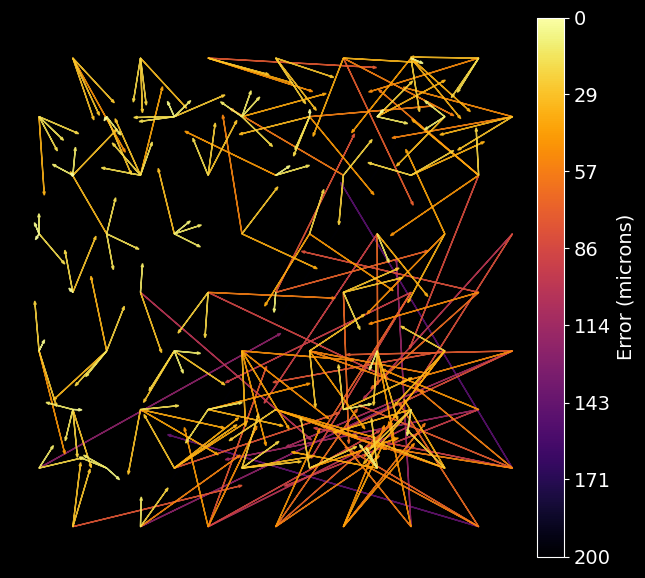

In [20]:
err = np.sqrt(np.sum((ptest - ytest)**2, axis=1))

clim = [0, 200]

cmap = mpl.cm.get_cmap('inferno')
norm = mpl.colors.Normalize(vmin=-clim[1], vmax=-clim[0])

plt.figure(figsize=(8,7))

ii = np.flip(np.argsort(err))

for k in range(len(ytest)):
    i = ii[k]
    # plt.quiver(ytest[:,0,0], ytest[:,0,1], 300*(ptest[:,0,0] - ytest[:,0,0]), 300*(ptest[:,0,1] - ytest[:,0,1]), angles='xy')
    plt.arrow(ytest[i,0], ytest[i,1], ptest[i,0] - ytest[i,0], ptest[i,1] - ytest[i,1], color=cmap(norm(-err[i])), length_includes_head=True, head_width=1, alpha=.9)
# ytest.squeeze().shape, ptest.shape


sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

cbar = plt.colorbar(sm, pad=.001)
cbar.set_label('Error (microns)')
cbar.ax.set_yticks(np.linspace(-clim[1],-clim[0],8))
cbar.ax.set_yticklabels([f"{abs(i):0.0f}" for i in np.linspace(-clim[1],-clim[0],8)])

plt.axis('square')
plt.axis('off')

In [21]:
def get_thresh(y,p, do_plotting = False):
    from scipy.optimize import curve_fit
    def logifunc(x,k):
        return 1. / (1 + np.exp(-k*x))


    N = len(y)

    i = np.triu_indices(N, 1)
    vyx = (y[:,None,0] - y[None,:,0])[i]
    vpx = (p[:,None,0] - p[None,:,0])[i]    
    vyy = (y[:,None,1] - y[None,:,1])[i]
    vpy = (p[:,None,1] - p[None,:,1])[i]

    d = np.sqrt(vyx**2 + vyy**2)
    b = ((vyx * vpx) + (vyy * vpy)) > 0

    k, _ = curve_fit(logifunc, d, b, p0=0.027)

    if do_plotting:
        di, ji = np.unique(np.round(d*100)/100, return_inverse=True)
        ndists = len(di)

        bsi = np.zeros(ndists)
        bi = np.zeros(ndists)

        for i in range(1,ndists):
            bi[i] = np.nanmean(b[ji==i])
            bsi[i] = np.nanstd(b[ji==i])/np.sqrt(np.count_nonzero(ji==i))

        di[0] = 0
        bi[0] = .5

        plt.errorbar(di,bi,bsi, linestyle='none', marker='o', capsize=3, capthick=3)
        
        ei = np.linspace(0, d.max(), 100)
        e = logifunc(ei, k.mean()) 
        plt.plot(ei,e)

        xl = plt.xlim()
        yl = plt.ylim()
        plt.cla()

        th = np.log(1/3)/-k.mean()
        plt.vlines(th,yl[0],.75,color='w')
        plt.hlines(.75, xl[0], th)        

        plt.plot(ei, e, 'w')
        plt.errorbar(di,bi,bsi, linestyle='none', marker='o', color="#4E2A84", capsize=3, capthick=3)


        plt.xlim(xl)
        plt.ylim(yl)
        # print(th)

        plt.xlabel('Distance (microns)')
        plt.ylabel('Discrimination accuracy')


    return np.log(1/3)/-k

array([38.44791344])

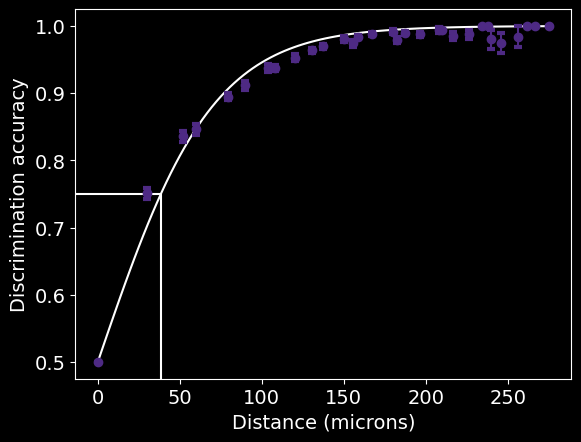

In [54]:
get_thresh(ytest, ptest, do_plotting=True)

9/9 [==============================] - 0s 3ms/step


array([45.65427883])

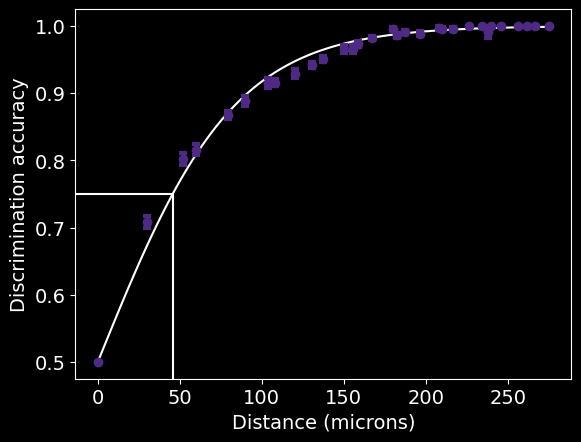

In [61]:
stest = xtest.copy().reshape((-1,4,2))

for c in range(nc):
    for i in range(ltest.max()):
        stest[ltest == i, c, :] = np.random.permutation(stest[ltest == i, c, :])

pstest = mod.predict(stest.reshape(xtest.shape))

get_thresh(ytest, pstest, do_plotting=True)

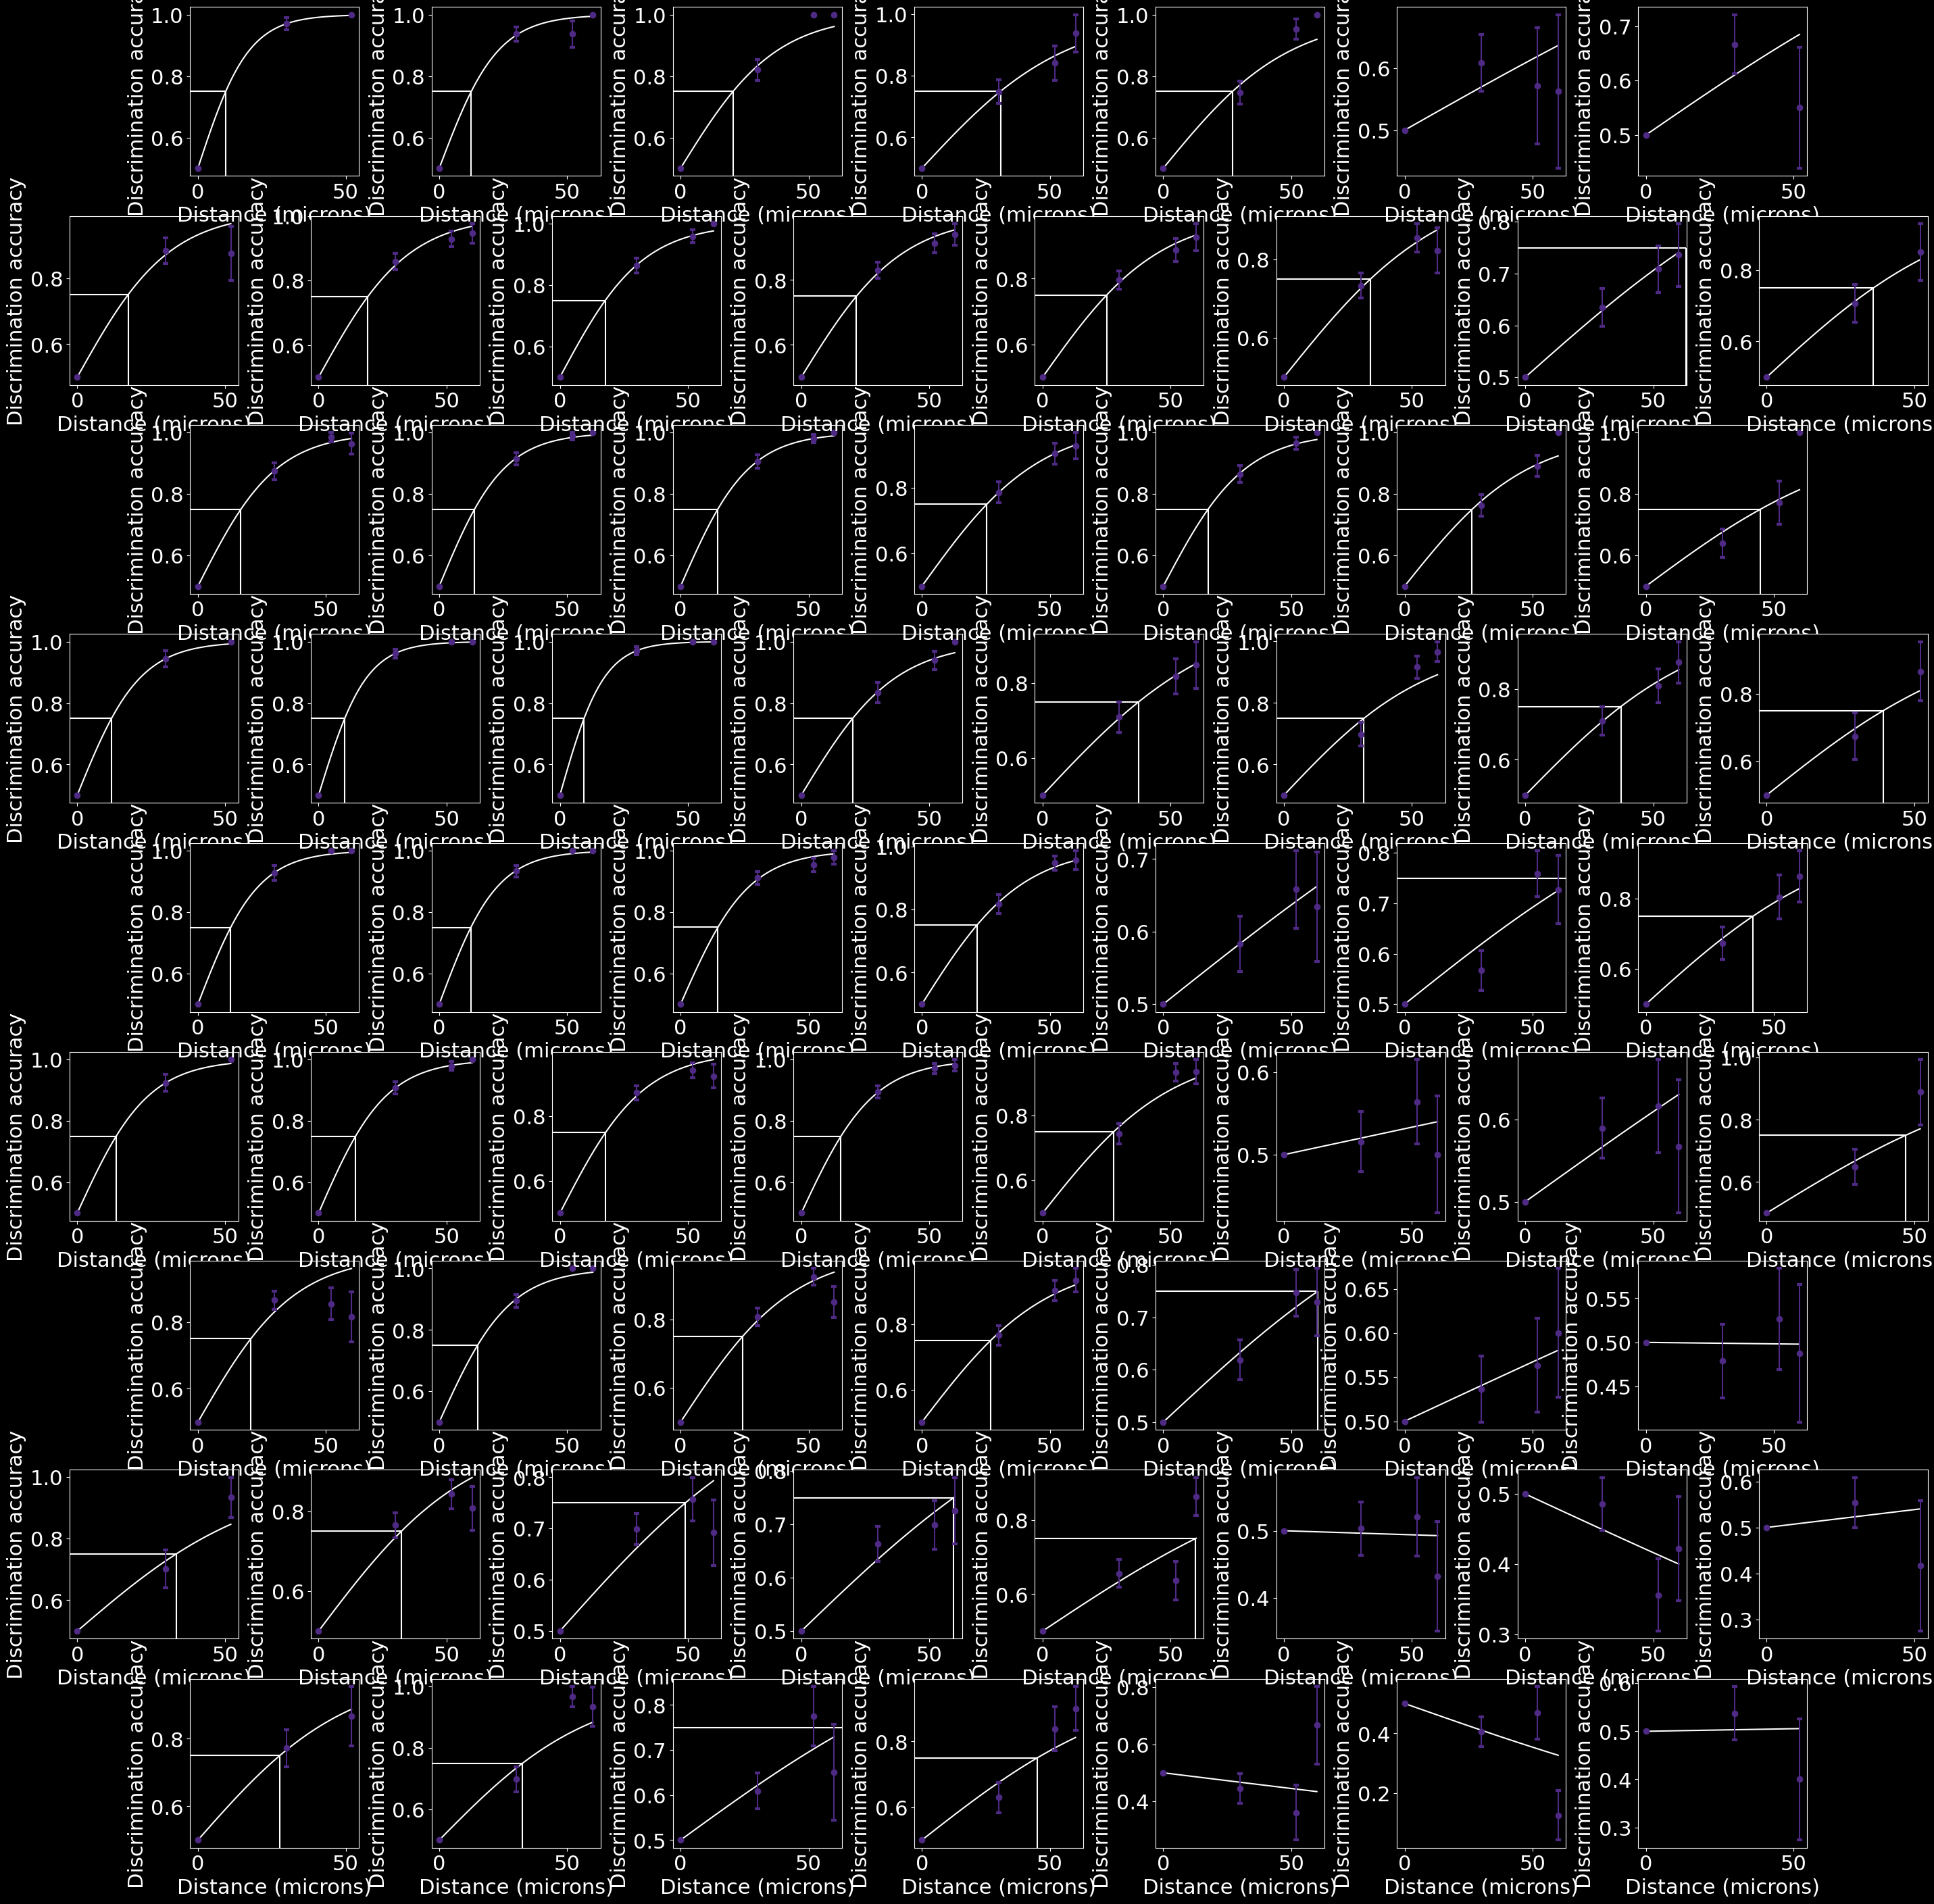

In [64]:

plt.figure(figsize=(25,25))

udist = np.sqrt(((u.T[:,None,:] - u.T[None,:,:])**2).sum(axis=-1))
th_map = np.zeros(u.shape[1])
for i,c in enumerate(u.T):
    j = np.argwhere(udist[i] < 30.1)
    
    k = np.isin(ui[test], j)
    # print(np.count_nonzero(k))

    t = (c + 105) / 210
    plt.axes([*t, .1, .1])

    th_map[i] = get_thresh(ytest[k], ptest[k], do_plotting=True)
    # th_map[i] = get_thresh(ytest[k], pstest[k], do_plotting=True)
    
th_map[th_map < 0] = np.infty

9.418774481733289 2561.0183912263437


C:\Users\zfj\AppData\Local\Temp\ipykernel_28436\44825499.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('inferno')
C:\Users\zfj\AppData\Local\Temp\ipykernel_28436\44825499.py:14: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, pad=.001)


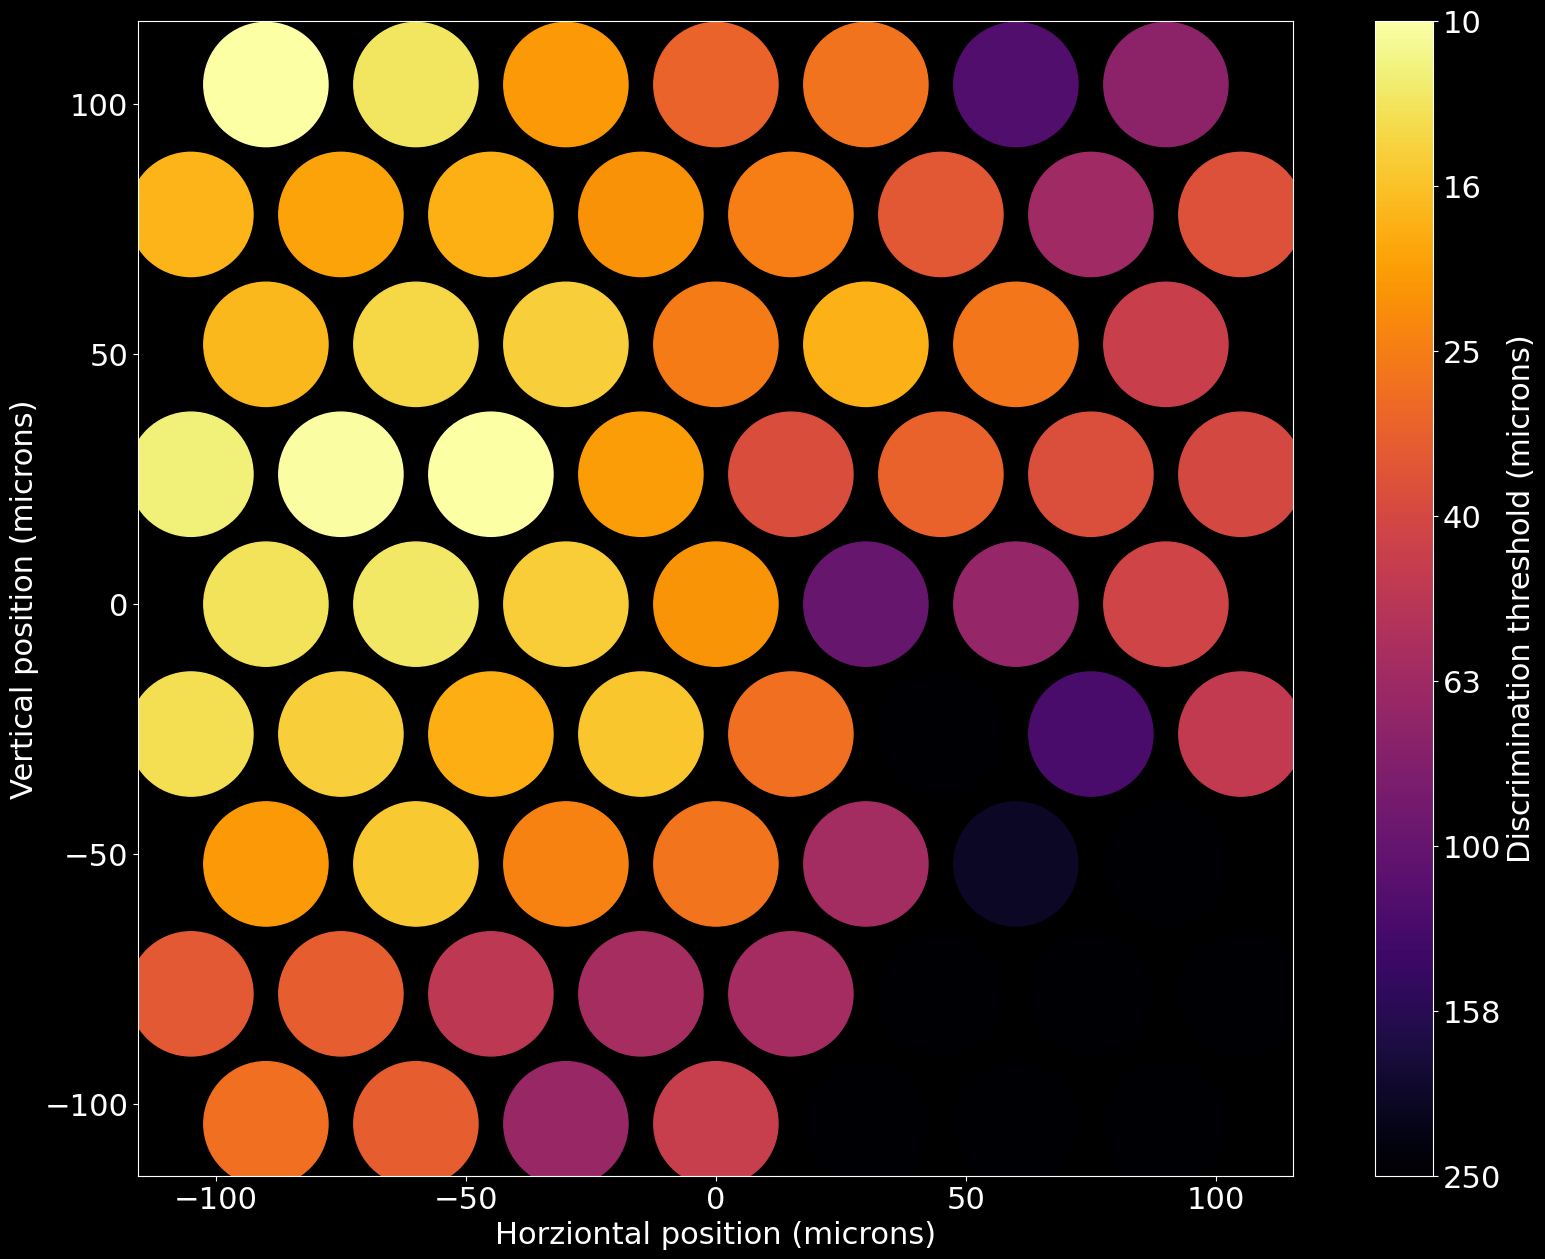

In [65]:
mpl.rcParams.update({'font.size': 22})


clim = [np.log10(10), np.log10(250)]

cmap = mpl.cm.get_cmap('inferno')
norm = mpl.colors.Normalize(vmin=-clim[1], vmax=-clim[0])

plt.figure(figsize=(20,15))
plt.scatter(*u, s=8000, c = cmap(norm(-np.log10(th_map))))

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

cbar = plt.colorbar(sm, pad=.001)
cbar.set_label('Discrimination threshold (microns)')
cbar.ax.set_yticks(np.linspace(-clim[1],-clim[0],8))
cbar.ax.set_yticklabels([f"{10**abs(i):0.0f}" for i in np.linspace(-clim[1],-clim[0],8)])

plt.xlabel('Horziontal position (microns)')
plt.ylabel('Vertical position (microns)')

plt.axis('square')

print(th_map.min(), th_map[~np.isinf(th_map)].max())
plt.show()

# nosie corr: 9.418774481733289 2561.0183912263437
# no noise corr: 12.348962823119741 254.42476311805797


In [68]:
width = 64
depth = 12

tmi = layers.Input(ncells * 2)
ffn = layers.Dense(width, activation='sigmoid')(tmi)
tmii = layers.LayerNormalization()(ffn)
ffn = tmii

for i in range(depth):
    ffn = layers.Dense(width, activation='sigmoid')(ffn)
    ffn = layers.Add()([tmii, ffn])
    ffn = layers.LayerNormalization()(ffn)

ffn = layers.Dense(2)(ffn)
smod = keras.Model(inputs=tmi, outputs = ffn)
smod.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 dense_28 (Dense)               (None, 64)           576         ['input_3[0][0]']                
                                                                                                  
 layer_normalization_26 (LayerN  (None, 64)          128         ['dense_28[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 dense_29 (Dense)               (None, 64)           4160        ['layer_normalization_26[0]

Epoch 1/200
74/74 [==============================] - 2s 8ms/step - loss: 4084.8020 - root_mean_squared_error: 63.9125 - val_loss: 3831.2209 - val_root_mean_squared_error: 61.8969
Epoch 2/200
74/74 [==============================] - 0s 3ms/step - loss: 3592.7849 - root_mean_squared_error: 59.9398 - val_loss: 3374.5679 - val_root_mean_squared_error: 58.0910
Epoch 3/200
74/74 [==============================] - 0s 3ms/step - loss: 3157.0342 - root_mean_squared_error: 56.1875 - val_loss: 2962.9758 - val_root_mean_squared_error: 54.4332
Epoch 4/200
74/74 [==============================] - 0s 3ms/step - loss: 2754.5784 - root_mean_squared_error: 52.4841 - val_loss: 2574.7261 - val_root_mean_squared_error: 50.7418
Epoch 5/200
74/74 [==============================] - 0s 3ms/step - loss: 2395.9380 - root_mean_squared_error: 48.9483 - val_loss: 2254.9602 - val_root_mean_squared_error: 47.4864
Epoch 6/200
74/74 [==============================] - 0s 3ms/step - loss: 2090.2278 - root_mean_squared_er

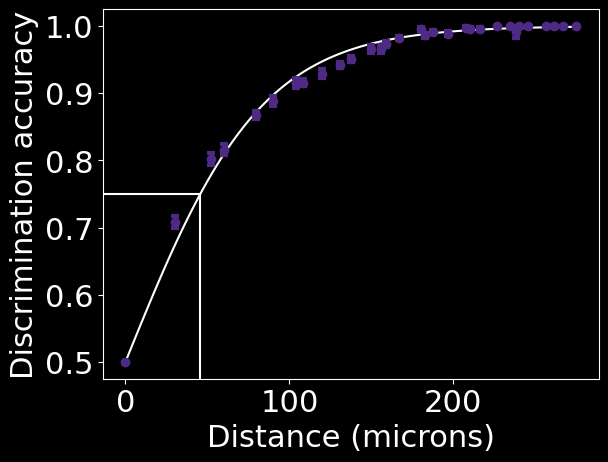

In [71]:
smod.compile(
    # loss = 'categorical_crossentropy',
    loss = 'mse',
    # loss = 'absolute_error',
    
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=tf.keras.metrics.RootMeanSquaredError()
)
strain = xtrain.copy().reshape((-1,4,2))

for c in range(nc):
    for i in range(ltrain.max()):
        strain[ltrain == i, c, :] = np.random.permutation(strain[ltrain == i, c, :])
strain = strain.reshape(xtrain.shape)

# get_thresh(ytest, pstest, do_plotting=True)
shistory = smod.fit(strain, ytrain, validation_data=(xtest,ytest), epochs=200, callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',restore_best_weights=True, patience=10, verbose=1))
# history = mod.fit(xtrain, ltrain, validation_data=(xtest,ltest), epochs=200, callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',restore_best_weights=True, patience=20, verbose=1))


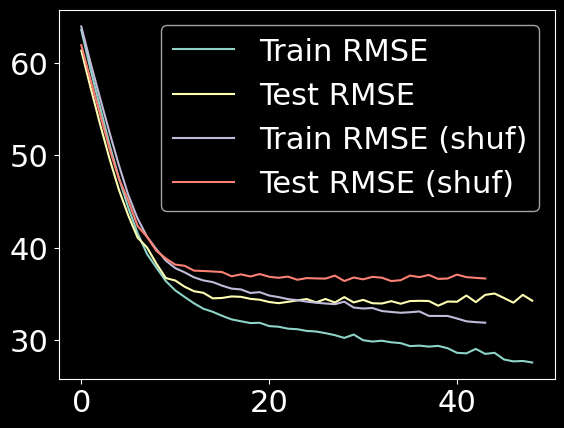

In [73]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.plot(shistory.history['root_mean_squared_error'])
plt.plot(shistory.history['val_root_mean_squared_error'])
plt.legend(['Train RMSE', 'Test RMSE', 'Train RMSE (shuf)', 'Test RMSE (shuf)'])


9/9 [==============================] - 0s 2ms/step


array([43.45488218])

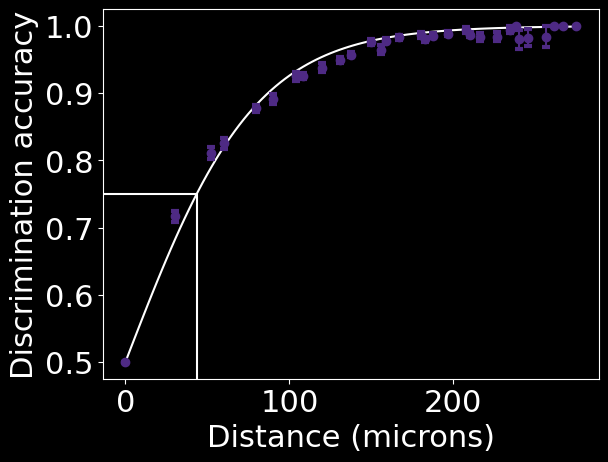

In [76]:
sptest = smod.predict(xtest)

sstest = xtest.copy().reshape((-1,4,2))

for c in range(nc):
    for i in range(ltest.max()):
        sstest[ltest == i, c, :] = np.random.permutation(sstest[ltest == i, c, :])

spstest = smod.predict(sstest.reshape(xtest.shape))

get_thresh(ytest, sptest, do_plotting=True)

array([42.91737985])

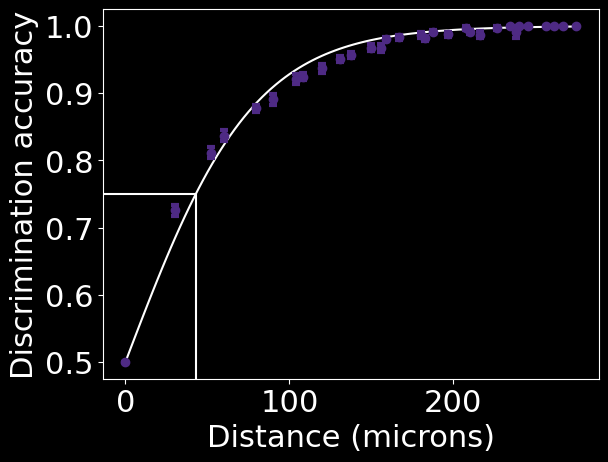

In [78]:
get_thresh(ytest, spstest, do_plotting=True)

In [127]:
# xtrain.shape
# np.tile(np.arange(10),(1,5)).shape
# ltrain.shape\
# np.unique(ltrain)
# np.unique(ltest)
j.shape

(4, 1)

In [146]:
#finally, what happens if we artificially inflate the sample size?
width = 64
depth = 24

tmi = layers.Input(ncells * 2)
ffn = layers.Dense(width, activation='sigmoid')(tmi)
tmii = layers.LayerNormalization()(ffn)
ffn = tmii

for i in range(depth):
    ffn = layers.Dense(width, activation='sigmoid')(ffn)
    ffn = layers.Add()([tmii, ffn])
    ffn = layers.LayerNormalization()(ffn)

ffn = layers.Dense(2)(ffn)
ssmod = keras.Model(inputs=tmi, outputs = ffn)

ssmod.compile(
    # loss = 'categorical_crossentropy',
    loss = 'mse',
    # loss = 'absolute_error',
    
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    metrics=tf.keras.metrics.RootMeanSquaredError()
)

# def shuffle(xd, yd, ld, N):
#     xd = xd.copy().reshape((-1,4,2))
    
#     xd_ = np.empty((ld.max(), N, 4, 2))
#     yd_ = np.empty((ld.max(), N, 2))
#     ld_ = np.tile(np.arange(ld.max()), (1, N))
#     # print(ld.shape)
#     for c in range(nc):
#         for i in range(ld.max()):
#             j = np.nonzero(ld == i)[0]
#             # print(i, j[0],)#j.shape)
#             j = np.random.choice(j, N)
#             xd_[i, :, c, :] = xd[j, c, :]
#             yd_[i, :] = yd[j]
#     xd_ = xd_.reshape((-1, 4, 2))
#     yd_ = yd_.reshape((-1, 2))

#     j = np.random.permutation(xd_.shape[0])

#     xd_ = xd_[j]
#     yd_ = yd_[j]
    
#     return xd, yd


# x_, y_ = shuffle(xtrain, ytrain, ltrain, 20)
# xt_, yt_ = shuffle(xtest, ytest, ltest, 20)

# get_thresh(ytest, pstest, do_plotting=True)
# sshistory = ssmod.fit(x_, y_, validation_data=(xt_,yt_), epochs=200, callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',restore_best_weights=True, patience=10, verbose=1))

class Shuffler(keras.utils.Sequence):
    def __init__(self, xd, yd, ld, N):
        xd = xd.copy().reshape((-1,4,2))
        self.N = N

        self.xd = np.empty((ld.max(), N, 4, 2))
        self.yd = np.empty((ld.max(), N, 2))
        self.ld = np.tile(np.arange(ld.max()), (1, N))
        # print(ld.shape)
        for c in range(nc):
            for i in range(ld.max()):
                j = np.nonzero(ld == i)[0]
                # print(i, j[0],)#j.shape)
                j = np.random.choice(j, N)
                self.xd[i, :, c, :] = xd[j, c, :]
                self.yd[i, :] = yd[j]
        
        self.xd = self.xd.reshape((-1, 4, 2))
        self.yd = self.yd.reshape((-1, 2))

        j = np.random.permutation(self.xd.shape[0])

        self.xd = self.xd[j]
        self.yd = self.yd[j]
        

    def __len__(self):
        return self.xd.shape[0]

    def __getitem__(self, idx):
        return self.xd[idx].reshape((-1, 8)), self.yd[idx].reshape((-1, 2))


# get_thresh(ytest, pstest, do_plotting=True)
sshistory = ssmod.fit(x = Shuffler(xtrain, ytrain, ltrain, 20), validation_data=Shuffler(xtest, ytest, ltest, 20), epochs=200, callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',restore_best_weights=True, patience=50, verbose=1))




Epoch 1/200
1320/1320 [==============================] - 10s 5ms/step - loss: 3403.3613 - root_mean_squared_error: 58.3383 - val_loss: 2623.8071 - val_root_mean_squared_error: 51.2231
Epoch 2/200
1320/1320 [==============================] - 6s 5ms/step - loss: 2127.9812 - root_mean_squared_error: 46.1300 - val_loss: 1813.8578 - val_root_mean_squared_error: 42.5894
Epoch 3/200
1320/1320 [==============================] - 7s 5ms/step - loss: 1631.0869 - root_mean_squared_error: 40.3867 - val_loss: 1643.9871 - val_root_mean_squared_error: 40.5461
Epoch 4/200
1320/1320 [==============================] - 7s 5ms/step - loss: 1466.8379 - root_mean_squared_error: 38.2993 - val_loss: 1552.6763 - val_root_mean_squared_error: 39.4040
Epoch 5/200
1320/1320 [==============================] - 6s 5ms/step - loss: 1394.6005 - root_mean_squared_error: 37.3443 - val_loss: 1494.9686 - val_root_mean_squared_error: 38.6648
Epoch 6/200
1320/1320 [==============================] - 6s 5ms/step - loss: 1364.59

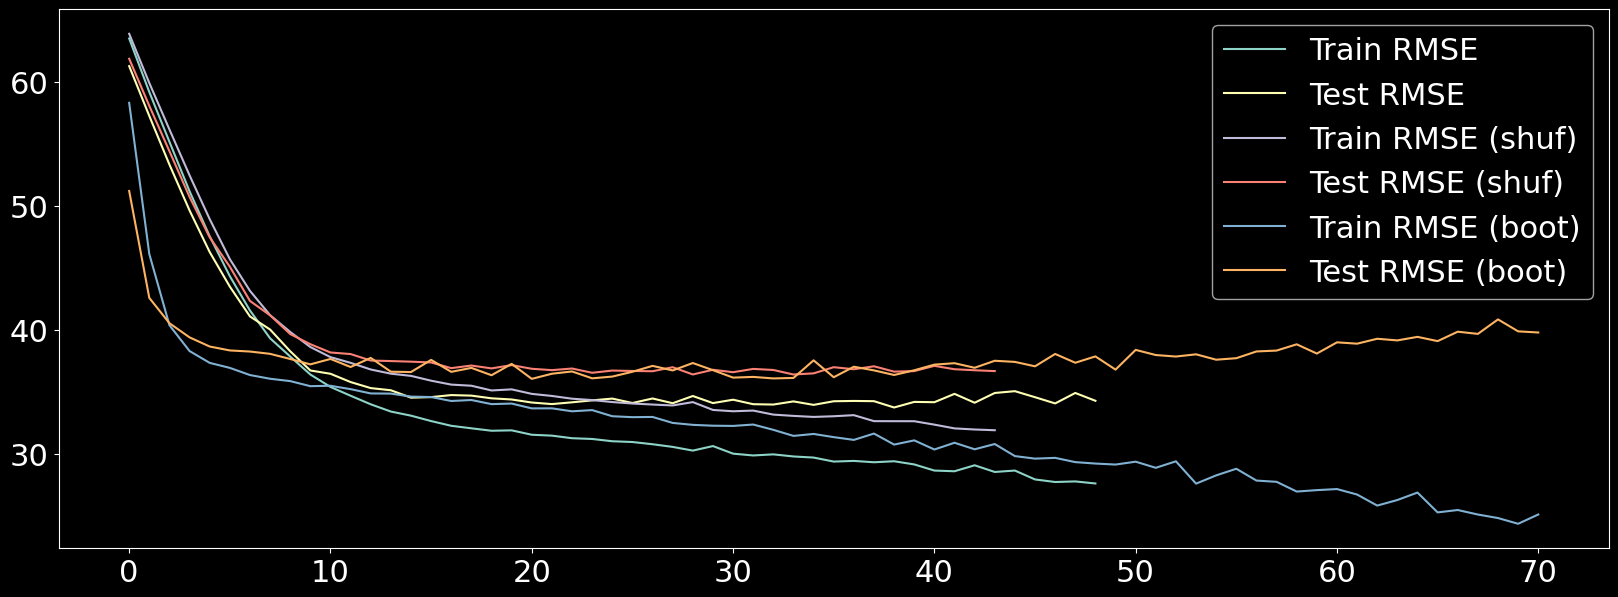

In [147]:
plt.figure(figsize=(20,7))
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.plot(shistory.history['root_mean_squared_error'])
plt.plot(shistory.history['val_root_mean_squared_error'])
plt.plot(sshistory.history['root_mean_squared_error'])
plt.plot(sshistory.history['val_root_mean_squared_error'])
plt.legend(['Train RMSE', 'Test RMSE', 'Train RMSE (shuf)', 'Test RMSE (shuf)', 'Train RMSE (boot)', 'Test RMSE (boot)'])


In [ ]:

m = loadmat(os.path.join(cell_data_path, f"{cell_id}.mat"), squeeze_me=True, struct_as_record=False)
# m = loadmat(os.path.join(cell_data_path, f"{cell_id}.mat"), squeeze_me=True)#, struct_as_record=False)

In [ ]:
def visit(f, depth=0):
    if type(f) == np.ndarray and f.dtype == object:
        for i,field in enumerate(f):
            print('\t'*depth, f"{i}:")
            visit(field, depth = depth + 1)
    elif type(f) == sio.matlab._mio5_params.mat_struct:
        for field in f._fieldnames:
            a = getattr(f,field)
            if type(a) == np.ndarray:
                astr = f"({len(a)})"
            else:
                astr = ""
            print('\t'*depth, field, astr)
            visit(a, depth = depth + 1)
    else:
        print('\t'*depth, f)

visit(m['data'])

 Stimulus (2)
	 0:
		 Name 
			 Light Step
		 Params 
			 NDF1 
				 5
			 NDF2 
				 4
			 Intensity 
				 0.2
			 RstarIntensity 
				 1997.152
			 MeanLevel 
				 0.1
			 RstarMeanLevel 
				 998.576
			 BackgroundSize 
				 1000
			 PreTime 
				 0.5
			 StimTime 
				 1
			 TailTime 
				 1
			 framesPerStep (0)
				 []
			 epochNum (10)
				 [ 1  2  3  4  5 16 17 18 19 20]
			 StagePosition (2)
				 [-291  827]
			 SpotSize 
				 340
		 RawData 
			 SplitParameter 
				 RstarIntensity
			 SplitValue 
				 1997.152
			 Data (4)
				 0:
					 0:
						 [   98   234   886  1080  1932  2410  3088  3287  4037  4562  4931  5101
  5253  5341  5528  5719  5777  5887  5938  5998  6101  6254  6504  6585
  6756  6876  7055  7197  7258  7438  7697  7861  8213  8310  8411  8609
  8829  8929  9103  9227  9768  9848 10118 10221 10701 11123 11390 11700
 11769 11869 12089 12454 12756 12851 13002 13184 13587 13771 14117 14237
 14402 14589 15194 15322 15525 18052 22696 23170 23991 24079 24178 24256

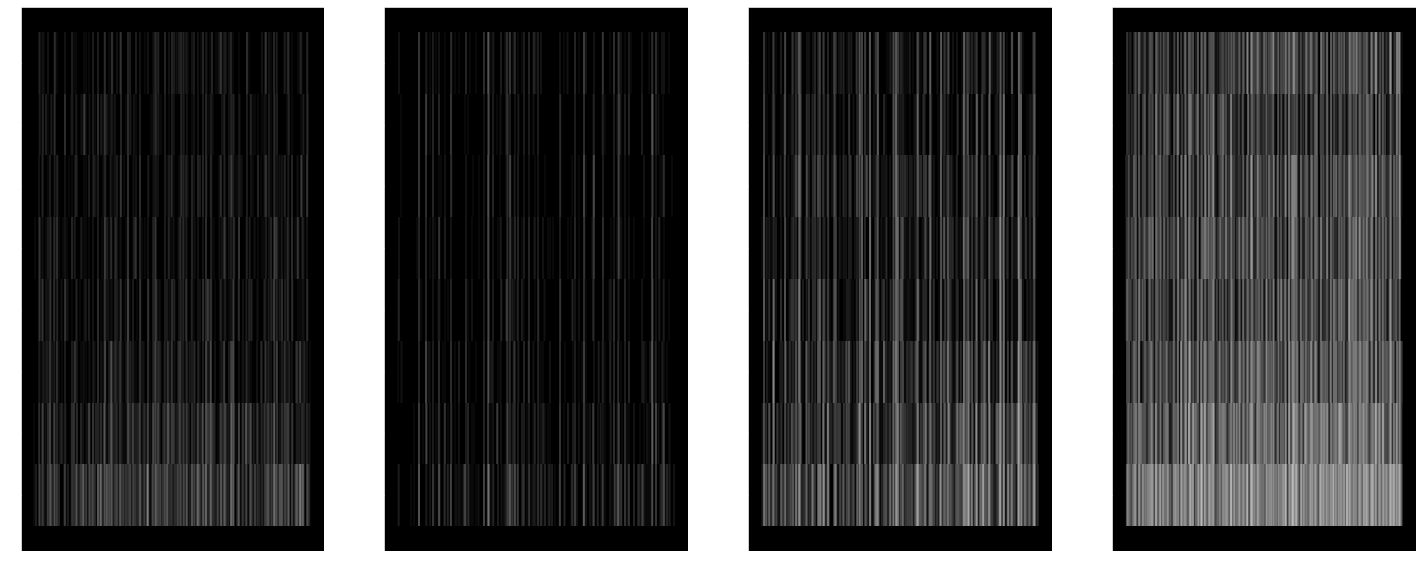

In [ ]:
_,axs = plt.subplots(1,4,figsize=(25,10))
for i in range(4):
    for j in range(8):
        axs.flat[i].vlines(m['data'].Stimulus[1].RawData.Data[i][j],j-0.5,j+0.5, alpha=.05)

X,Y,intensity,startTime,endTime,diameter,flickerFrequency


(-110.0, 110.0, -103.56220453588912, 110.77908290075946)

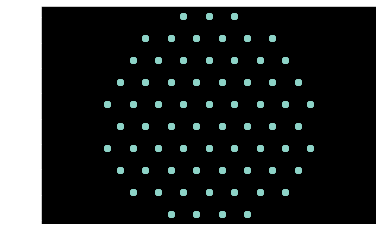

In [ ]:
print(m['data'].Stimulus[1].Params.ShapeDataColumns[0])
m['data'].Stimulus[1].Params.ShapeDataMatrix[0]

#diam 23.5um, intensity 1, flicker none,

plt.scatter(m['data'].Stimulus[1].Params.ShapeDataMatrix[0][:,0], m['data'].Stimulus[1].Params.ShapeDataMatrix[0][:,1])
plt.axis('equal')

In [ ]:
sd = np.concatenate([np.concatenate((sdm, i*np.ones((len(sdm),1))), axis=1) for i,sdm in enumerate(m['data'].Stimulus[1].Params.ShapeDataMatrix)], axis=0)
print(sd.shape)
u, ui = np.unique(sd[:,:2], axis = 0, return_inverse = True)
print(u.shape, ui.shape)

(2760, 8)
(69, 2) (2760,)


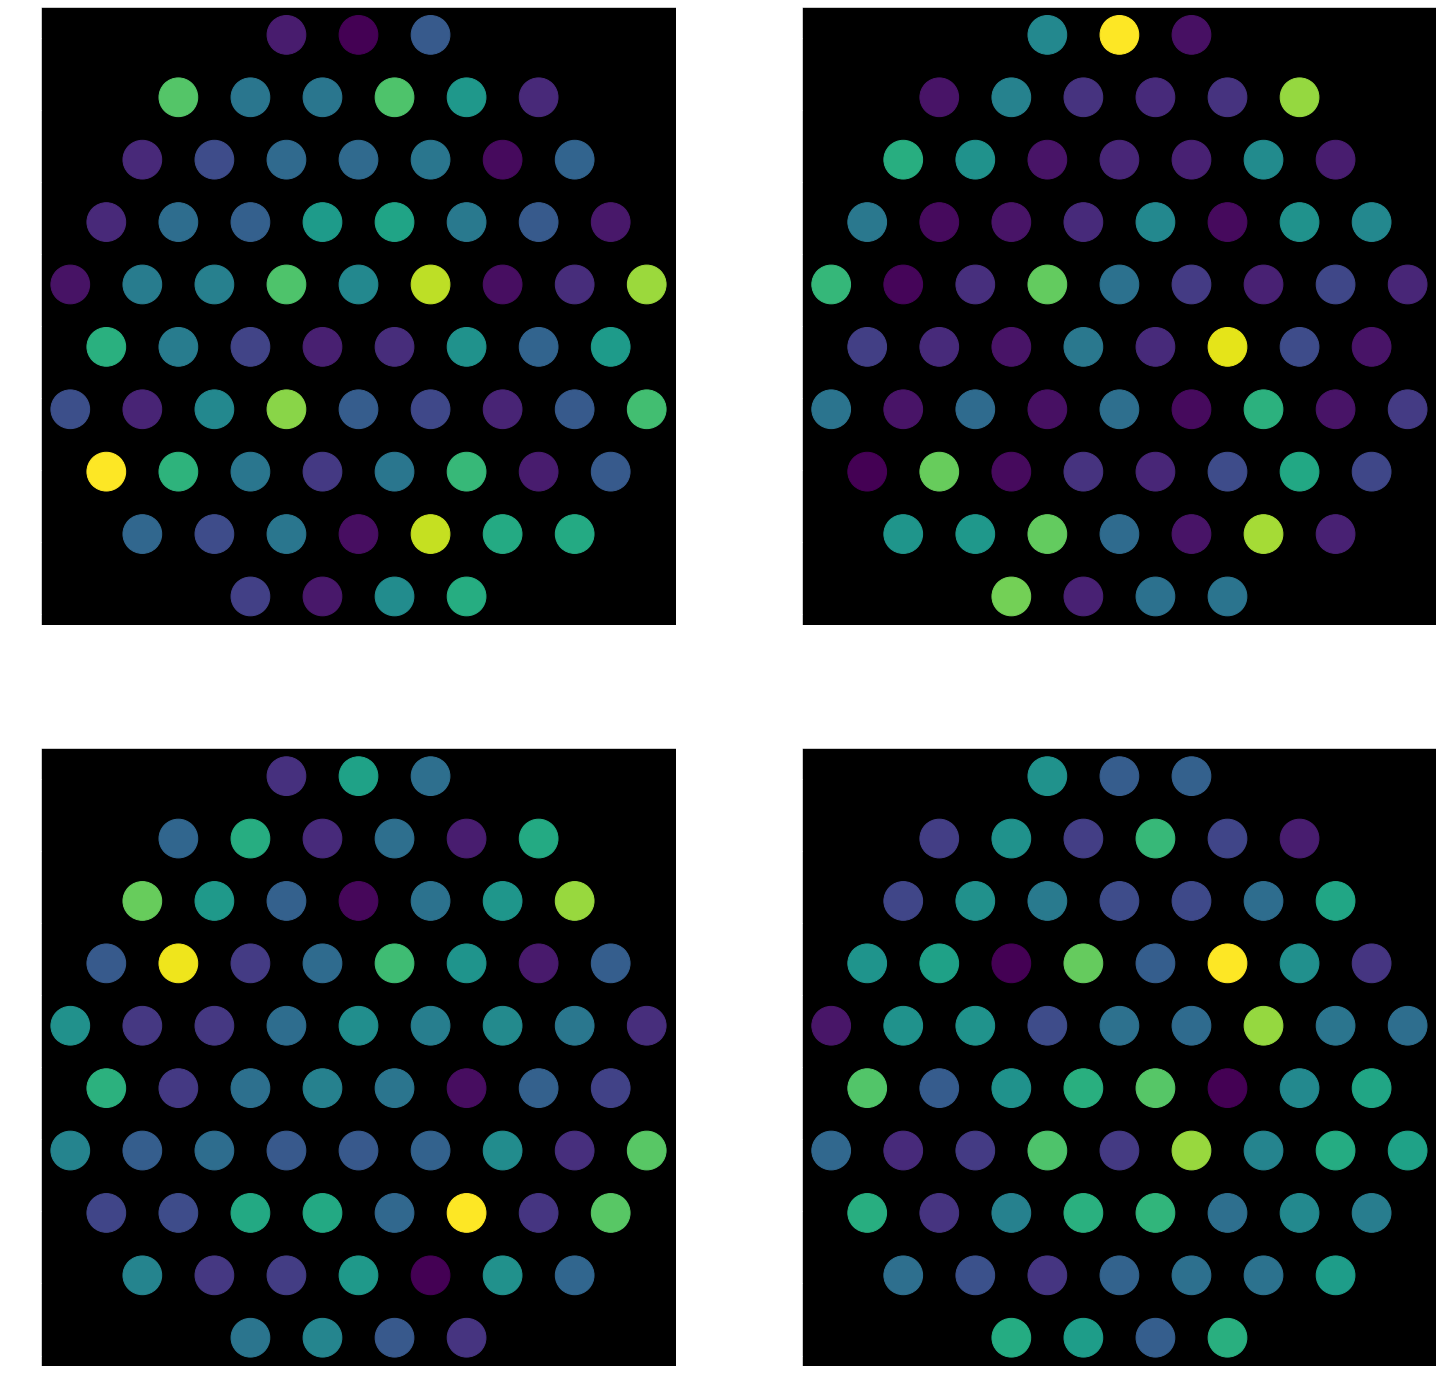

In [ ]:
#plot the average spike count vs spot position

nt = np.empty((4, len(u)))
ns = np.zeros((4, len(u)))


rd = m['data'].Stimulus[1].RawData.Data

fig,axs = plt.subplots(2,2,figsize=(25,25))
axs = axs.flatten()
for j in [0,1,2,3]: #cells
    for i in range(len(u)):
        x,y = u[i]
        t0,tf = sd[ui==i,3:5].T
        ti = sd[ui==i,-1].astype(int)
        
        t0 = (t0*10000).astype(int) - 500 - 2500
        tf = (tf*10000).astype(int) + 2000 - 2500
        
        keep = t0 > 0
        t0 = t0[keep]
        tf = tf[keep]       
        
        nt[j][i] = len(t0)

        for tt0,ttf in zip(t0,tf):
            for k in range(8):
                # print(np.logical_and(rd[j][k] < ttf, rd[j][k] >= tt0).shape)
                ns[j][i] += np.count_nonzero(np.logical_and(rd[j][k] < ttf, rd[j][k] >= tt0))
    
    s = axs[j].scatter(u[:,0], u[:,1], 1500, ns[j]/nt[j], cmap='viridis')#, vmin=0, vmax=80)

# fig.colorbar(s, ax=axs, shrink=.95)